## Data quality check / cleaning / preparation 



*By Diego Schummer*

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import itertools
import time
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV
from sklearn.preprocessing import StandardScaler 
from sklearn.metrics import r2_score


from sklearn.feature_selection import RFE
import statsmodels.formula.api as sm

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [3]:
#make list of cat_vars and num_vars from predictors_actors and predictors_genre and standard_predictors based o nthe values
num_vars = ['duration', 'director_facebook_likes', 'actor_3_facebook_likes', 'actor_1_facebook_likes', 'gross', 'cast_total_facebook_likes', 'facenumber_in_poster', 'budget', 'actor_2_facebook_likes', 'aspect_ratio', 'profit']

cat_vars = ['director_name', 'actor_2_name', 'actor_1_name', 'actor_3_name','genres']



In [4]:

# Display distribution of numeric variables
for var in num_vars:
    print('\n' + var)
    print('Number of missing values:', train[var].isnull().sum())
    print(train[var].describe())


duration
Number of missing values: 0
count    3005.000000
mean      110.166057
std        22.366858
min        37.000000
25%        96.000000
50%       106.000000
75%       120.000000
max       330.000000
Name: duration, dtype: float64

director_facebook_likes
Number of missing values: 0
count     3005.000000
mean       769.535774
std       2962.943145
min          0.000000
25%         11.000000
50%         65.000000
75%        243.000000
max      23000.000000
Name: director_facebook_likes, dtype: float64

actor_3_facebook_likes
Number of missing values: 0
count     3005.000000
mean       757.035275
std       1865.411805
min          0.000000
25%        190.000000
50%        436.000000
75%        690.000000
max      23000.000000
Name: actor_3_facebook_likes, dtype: float64

actor_1_facebook_likes
Number of missing values: 0
count      3005.000000
mean       7656.826955
std       16240.628849
min           0.000000
25%         742.000000
50%        1000.000000
75%       12000.000000
ma

In [5]:
# Display distribution of categorical variables,Distribution of a categorical variable must include the number of missing values, the number of unique values, the frequency of all its levels. If a categorical variable has too many levels, you may just include the counts of the top 3-5 levels. 
#top 3 common values and coorsponding counts

for var in cat_vars:
    print('\n' + var)
    print('Number of missing values:', train[var].isnull().sum())
    print('Number of unique values:', train[var].nunique())
    print(train[var].value_counts().head(3))
    
    



director_name
Number of missing values: 0
Number of unique values: 1455
Steven Spielberg    21
Clint Eastwood      15
Woody Allen         14
Name: director_name, dtype: int64

actor_2_name
Number of missing values: 0
Number of unique values: 1866
Morgan Freeman     15
Charlize Theron    13
Scott Glenn         9
Name: actor_2_name, dtype: int64

actor_1_name
Number of missing values: 0
Number of unique values: 1250
Johnny Depp          30
Robert De Niro       30
Denzel Washington    27
Name: actor_1_name, dtype: int64

actor_3_name
Number of missing values: 0
Number of unique values: 2188
Steve Coogan      7
Ben Mendelsohn    7
Robert Duvall     6
Name: actor_3_name, dtype: int64

genres
Number of missing values: 0
Number of unique values: 664
Comedy|Drama|Romance    122
Comedy|Drama            116
Comedy                  112
Name: genres, dtype: int64


### Data cleaning
*By Diego Schummer*


In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

import statsmodels.formula.api as smf



In [7]:
#read in movie data
df = pd.read_csv('movie_metadata.csv')


## Data Cleaning

In [8]:


#create profit column
df['profit'] = df['gross'] - df['budget']


In [9]:
#remove missing values
df = df.drop(columns=['color'])
n_original = len(df)
df.dropna(inplace=True)
n_null_removed = len(df)
print("original size, new size: "+ str(n_original)+", " +str(n_null_removed))


original size, new size: 5043, 3757


In [10]:
df["title_year"] = df["title_year"].astype(int)


## Exploratory Data Analysis

*By Diego Schummer*

In [11]:
# create bins based on quartiles of the "gross" variable
df['gross_bin'] = pd.qcut(df['gross'], 4, labels=False)
# normalize "gross_bins" to have values in the range [0, 1]
df['gross_bin'] = df['gross_bin'] / df['gross_bin'].max()


In [12]:
df['gross_bin'].value_counts()

0.000000    940
0.333333    940
1.000000    939
0.666667    938
Name: gross_bin, dtype: int64

In [13]:
df["title_year"] = df["title_year"].astype(int)


### Genres

In [14]:
# create binary variables for each genre
genres_df = df['genres'].str.get_dummies(sep='|')
df = pd.concat([df, genres_df], axis=1)

#lowercase column names
df.columns = map(str.lower, df.columns)

df = df.rename(columns={'sci-fi': 'sci_fi'})

#remove rows having genres with combiend revenue = 0 (film_noir,,game_shwo, reality_tv)

df = df[df['genres'] != 'film_noir']
df = df[df['genres'] != 'game_show']
df = df[df['genres'] != 'reality_tv']
#remove genres column



### Actors


In [15]:
df_people = df[["director_name", "director_facebook_likes",  "actor_1_name", "actor_1_facebook_likes","actor_2_name", "actor_2_facebook_likes", "actor_3_name","actor_3_facebook_likes", "cast_total_facebook_likes",  "profit"]]
yay = df_people.groupby(["director_name","actor_1_name", "actor_2_name", "actor_3_name"])[["profit"]].agg("mean").sort_values(by = "profit", ascending=False)
df_people.groupby(["director_name","actor_1_name", "actor_2_name", "actor_3_name"]).agg("count")
director = df_people.groupby(["director_name"])[["profit"]].agg("mean").sort_values(by = "profit", ascending=False).reset_index()
actor_1 = df_people.groupby(["actor_1_name"])[["profit"]].agg("mean").sort_values(by = "profit", ascending=False).reset_index()
actor_2 = df_people.groupby(["actor_2_name"])[["profit"]].agg("mean").sort_values(by = "profit", ascending=False).reset_index()
actor_3 = df_people.groupby(["actor_3_name"])[["profit"]].agg("mean").sort_values(by = "profit", ascending=False).reset_index()
director_high = [x for x in director['director_name'].iloc[:(round(len(director)/2))]]
director_low = [x for x in director['director_name'].iloc[(round(len(director)/2)):len(director)]]
actor_1_high = [x for x in actor_1['actor_1_name'].iloc[:(round(len(actor_1)/2))]]
actor_1_low = [x for x in actor_1['actor_1_name'].iloc[(round(len(actor_1)/2)):len(actor_1)]]
actor_2_high = [x for x in actor_2['actor_2_name'].iloc[:(round(len(actor_2)/2))]]
actor_2_low = [x for x in actor_2['actor_2_name'].iloc[(round(len(actor_2)/2)):len(actor_2)]]
actor_3_high = [x for x in actor_3['actor_3_name'].iloc[:(round(len(actor_3)/2))]]
actor_3_low = [x for x in actor_3['actor_3_name'].iloc[(round(len(actor_3)/2)):len(actor_3)]]
df["director_high"] = [1 if director_high.count(x) > 0 else 0 for x in df["director_name"]]
df["director_low"] = [1 if director_low.count(x) > 0 else 0 for x in df["director_name"]]
df["actor_1_high"] = [1 if actor_1_high.count(x) > 0 else 0 for x in df["actor_1_name"]]
df["actor_1_low"] = [1 if actor_1_low.count(x) > 0 else 0 for x in df["actor_1_name"]]
df["actor_2_high"] = [1 if actor_2_high.count(x) > 0 else 0 for x in df["actor_2_name"]]
df["actor_2_low"] = [1 if actor_2_low.count(x) > 0 else 0 for x in df["actor_2_name"]]
df["actor_2_high"] = [1 if actor_2_high.count(x) > 0 else 0 for x in df["actor_2_name"]]
df["actor_2_low"] = [1 if actor_2_low.count(x) > 0 else 0 for x in df["actor_2_name"]]
df["actor_3_high"] = [1 if actor_3_high.count(x) > 0 else 0 for x in df["actor_3_name"]]
df["actor_3_low"] = [1 if actor_3_low.count(x) > 0 else 0 for x in df["actor_3_name"]]

In [16]:
df["is_english"] = [1 if x == "English" else 0 for x in df["language"]]


### Binary Profit

In [17]:
df['profit_binary'] = np.where(df['profit'] > 0, 1, 0)


### Remove Post Release Metrics


In [18]:
post_release_metrics = ['imdb_score', 'num_voted_users', 'num_user_for_reviews', 'num_critic_for_reviews', 'movie_facebook_likes']
df = df.drop(columns=post_release_metrics)

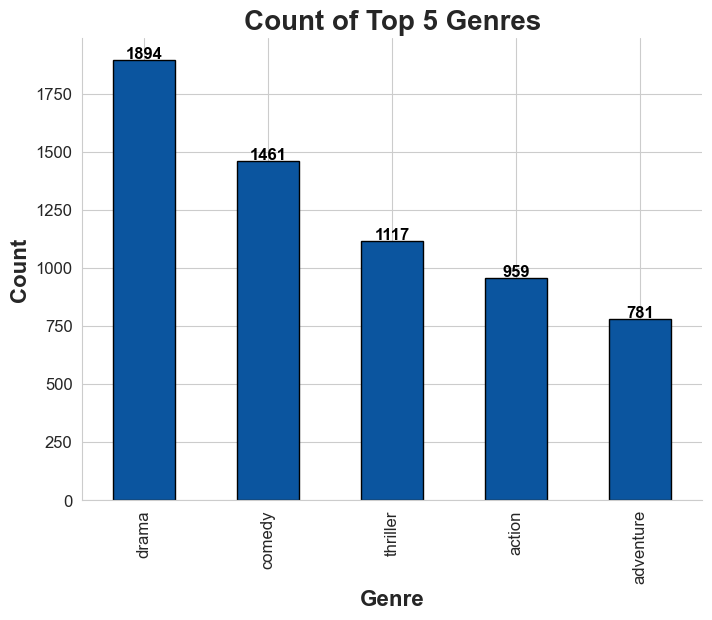

In [19]:
#plot count of each genre for top 5 genres
import matplotlib.pyplot as plt
import seaborn as sns

# Select top 5 genres
top_genres = df[['action', 'adventure', 'comedy', 'drama', 'thriller']].sum().sort_values(ascending=False).head(5)

# Set style and colors
sns.set_style("whitegrid")
sns.set_palette("Blues_r")

# Plot bar chart
ax = top_genres.plot(kind='bar', figsize=(8, 6), edgecolor='black')

# Set titles and labels
ax.set_title("Count of Top 5 Genres", fontsize=20, fontweight='bold')
ax.set_xlabel("Genre", fontsize=16, fontweight='bold')
ax.set_ylabel("Count", fontsize=16, fontweight='bold')

# Set tick label font size
ax.tick_params(labelsize=12)

# Remove top and right spines
sns.despine(top=True, right=True)

# Add value labels to each bar
for i, v in enumerate(top_genres):
    ax.text(i, v + 5, str(v), color='black', fontweight='bold', ha='center', fontsize=12)

plt.show()


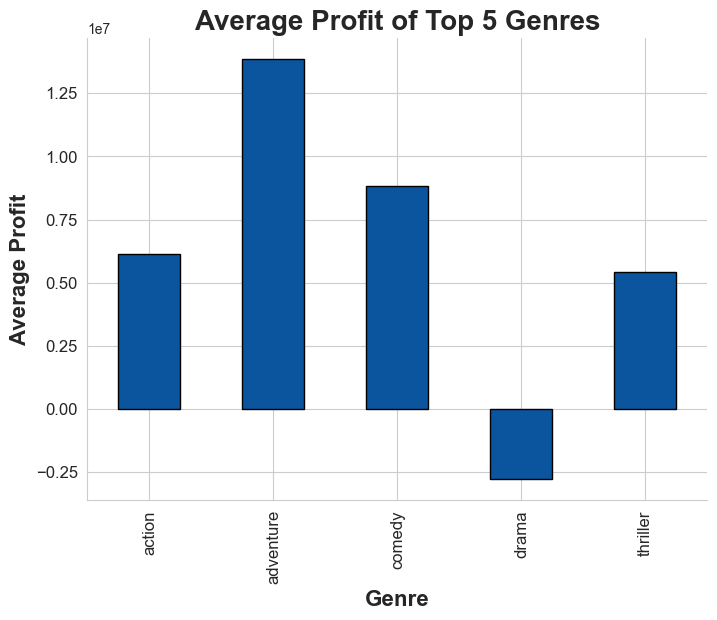

In [20]:
import matplotlib.pyplot as plt

# Select the top 5 genres
top_genres = ['action', 'adventure', 'comedy', 'drama', 'thriller']

#avg profit for each genre in top 5 genres

avg_profit = []
for genre in top_genres:
    avg_profit.append(df[df[genre] == 1]['profit'].mean())


# Set style and colors
sns.set_style("whitegrid")
sns.set_palette("Blues_r")

# Plot bar chart
ax = pd.Series(avg_profit, index=top_genres).plot(kind='bar', figsize=(8, 6), edgecolor='black')

# Set titles and labels
ax.set_title("Average Profit of Top 5 Genres", fontsize=20, fontweight='bold')
ax.set_xlabel("Genre", fontsize=16, fontweight='bold')
ax.set_ylabel("Average Profit", fontsize=16, fontweight='bold')

# Set tick label font size
ax.tick_params(labelsize=12)

# Remove top and right spines
sns.despine(top=True, right=True)

plt.show()




In [21]:
# Split the data into training and testing sets
train_data, test_data = train_test_split(df, test_size=0.2, random_state=42)

# Save the training and testing data as CSV files
train_data.to_csv('train.csv', index=False)
test_data.to_csv('test.csv', index=False)

In [22]:
#export cleaned_data
df = df.drop(columns=['genres'])
df.to_csv('cleaned_data.csv', index=False)


### Data preparation
*By Yasmeen Nahas*

The following data preparation steps helped us to prepare our data for implementing various modeling / validation techniques:

1. Made categorical variables for profitability of cast / director to use as a predictor in the model!

**Making of the Cast and Director Profitability Varibale: Categorical Variables Transformatiom**

*By Yasmeen Nahas*

In [23]:
#import cleaned
df = pd.read_csv('cleaned_data.csv')

In [24]:
yay = df_people.groupby(["director_name","actor_1_name", "actor_2_name", "actor_3_name"])[["profit"]].agg("mean").sort_values(by = "profit", ascending=False)
yay

,,,,profit
director_name,actor_1_name,actor_2_name,actor_3_name,
James Cameron,CCH Pounder,Joel David Moore,Wes Studi,5.235058e+08
Colin Trevorrow,Bryce Dallas Howard,Judy Greer,Omar Sy,5.021773e+08
James Cameron,Leonardo DiCaprio,Kate Winslet,Gloria Stuart,4.586723e+08
George Lucas,Harrison Ford,Peter Cushing,Kenny Baker,4.499357e+08
Steven Spielberg,Henry Thomas,Dee Wallace,Peter Coyote,4.244495e+08
...,...,...,...,...
Katsuhiro Ôtomo,William Hootkins,Robin Atkin Downes,Rosalind Ayres,-2.127110e+09
Hayao Miyazaki,Minnie Driver,Jada Pinkett Smith,Billy Crudup,-2.397702e+09
Lajos Koltai,Marcell Nagy,Péter Fancsikai,Bálint Péntek,-2.499804e+09


In [25]:
yay[:3]

,,,,profit
director_name,actor_1_name,actor_2_name,actor_3_name,
James Cameron,CCH Pounder,Joel David Moore,Wes Studi,523505847.0
Colin Trevorrow,Bryce Dallas Howard,Judy Greer,Omar Sy,502177271.0
James Cameron,Leonardo DiCaprio,Kate Winslet,Gloria Stuart,458672302.0


In [26]:
df_people.groupby(["director_name","actor_1_name", "actor_2_name", "actor_3_name"]).agg("count")

,,,,director_facebook_likes,actor_1_facebook_likes,actor_2_facebook_likes,actor_3_facebook_likes,cast_total_facebook_likes,profit
director_name,actor_1_name,actor_2_name,actor_3_name,,,,,,
Aaron Schneider,Bill Murray,Robert Duvall,Bill Cobbs,1,1,1,1,1,1
Aaron Seltzer,Alyson Hannigan,Carmen Electra,Fred Willard,1,1,1,1,1,1
Abel Ferrara,Isabella Rossellini,Vincent Gallo,Gretchen Mol,1,1,1,1,1,1
Adam Goldberg,Judy Greer,Marisa Coughlan,Nicky Katt,1,1,1,1,1,1
Adam Marcus,Kane Hodder,Leslie Jordan,Erin Gray,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...
Zack Snyder,Ty Burrell,Kevin Zegers,Mekhi Phifer,2,2,2,2,2,2
Zak Penn,Zak Penn,Gabriel Beristain,John Bailey,1,1,1,1,1,1
Zal Batmanglij,Alexander Skarsgård,Julia Ormond,Jason Ritter,1,1,1,1,1,1


Most profitable combination of director and actors is James Cameron, CCH Pounder, Joel David Moore, and Wes Studi.

In [27]:
director = df_people.groupby(["director_name"])[["profit"]].agg("mean").sort_values(by = "profit", ascending=False).reset_index()
director

,director_name,profit
0,Tim Miller,3.050243e+08
1,George Lucas,2.773283e+08
2,Richard Marquand,2.766254e+08
3,Kyle Balda,2.620296e+08
4,Colin Trevorrow,2.527175e+08
...,...,...
1654,Takao Okawara,-9.899626e+08
1655,Chan-wook Park,-1.403635e+09
1656,Katsuhiro Ôtomo,-1.613335e+09
1657,Lajos Koltai,-2.499804e+09


In [28]:
actor_1 = df_people.groupby(["actor_1_name"])[["profit"]].agg("mean").sort_values(by = "profit", ascending=False).reset_index()
actor_1

,actor_1_name,profit
0,Wayne Knight,2.937840e+08
1,Rupert Everett,2.864710e+08
2,Catherine Dyer,2.269504e+08
3,Henry Thomas,2.113146e+08
4,Kathleen Freeman,2.076520e+08
...,...,...
1423,Mitsuo Iwata,-1.099561e+09
1424,Min-sik Choi,-1.404099e+09
1425,William Hootkins,-2.127110e+09
1426,Marcell Nagy,-2.499804e+09


In [29]:
actor_2 = df_people.groupby(["actor_2_name"])[["profit"]].agg("mean").sort_values(by = "profit", ascending=False).reset_index()
actor_2


,actor_2_name,profit
0,Peter Cushing,4.499357e+08
1,Robert Downey Jr.,3.385169e+08
2,Ed Skrein,3.050243e+08
3,Leonard Roberts,2.913236e+08
4,Jennifer Saunders,2.864710e+08
...,...,...
2184,Robin Atkin Downes,-1.070511e+09
2185,Takeshi Kusao,-1.099561e+09
2186,Péter Fancsikai,-2.499804e+09
2187,Yeong-ae Lee,-4.199788e+09


In [30]:
actor_3 = df_people.groupby(["actor_3_name"])[["profit"]].agg("mean").sort_values(by = "profit", ascending=False).reset_index()
actor_3

,actor_3_name,profit
0,Omar Sy,5.021773e+08
1,Gloria Stuart,4.586723e+08
2,Niketa Calame,3.777838e+08
3,Ian McDiarmid,3.595447e+08
4,Anthony Reynolds,3.299993e+08
...,...,...
2583,Tesshô Genda,-1.099561e+09
2584,Hye-jeong Kang,-2.100304e+09
2585,Rosalind Ayres,-2.127110e+09
2586,Bálint Péntek,-2.499804e+09


In [31]:
director_high = list(director.loc[director["profit"] > 0]["director_name"])
director_high

['Tim Miller',
 'George Lucas',
 'Richard Marquand',
 'Kyle Balda',
 'Colin Trevorrow',
 'Chris Buck',
 'Joss Whedon',
 'Yarrow Cheney',
 'Pierre Coffin',
 'Lee Unkrich',
 'Roger Allers',
 'William Cottrell',
 'James Cameron',
 'Peter Faiman',
 'Pete Docter',
 'Francis Lawrence',
 'Irvin Kershner',
 'Daniel Myrick',
 'Andrew Adamson',
 'Joel Zwick',
 'Sam Taylor-Johnson',
 'George Roy Hill',
 'Phil Lord',
 'Josh Boone',
 'Gary Ross',
 'Peter Farrelly',
 'Jon Favreau',
 'David Silverman',
 'Oren Peli',
 'Victor Fleming',
 'Penelope Spheeris',
 'Robert Wise',
 'Christopher Nolan',
 'Leonard Nimoy',
 'Steven Spielberg',
 'Shane Black',
 'Randal Kleiser',
 'Robert Stevenson',
 'John Lasseter',
 'Michael Sucsy',
 'Rawson Marshall Thurber',
 'John G. Avildsen',
 'John Cornell',
 'Jay Roach',
 'Chris Miller',
 'Paul Tibbitt',
 'Mike Gabriel',
 'Chris Columbus',
 'Todd Phillips',
 'Jeannot Szwarc',
 'Tod Williams',
 'Norman Ferguson',
 'Jeff Tremaine',
 'P.J. Hogan',
 'David Slade',
 'Jim Abra

In [32]:
director_low = list(director.loc[director["profit"] <= 0]["director_name"])
director_low

['Hunter Richards',
 'Michel Orion Scott',
 'Woody Allen',
 'Marc Levin',
 'Brandon Trost',
 'Jean-François Richet',
 'Cédric Klapisch',
 'George Miller',
 'Joe Swanberg',
 'Bill Plympton',
 'Mike Mills',
 'Xavier Beauvois',
 'Ricky Gervais',
 'Hans Canosa',
 'Clark Gregg',
 'John Sayles',
 'Richard LaGravenese',
 'Matt Piedmont',
 'Tom Putnam',
 'Eric Valette',
 'E.L. Katz',
 'Steve James',
 'Jon Gunn',
 "Eddie O'Flaherty",
 'Ricki Stern',
 'Richard Dutcher',
 'Eric Schaeffer',
 'Henry Alex Rubin',
 'Nadine Labaki',
 'C. Jay Cox',
 'Neema Barnette',
 'Gareth Edwards',
 'Lucio Fulci',
 'Fabián Bielinsky',
 'Bruce Dellis',
 'Jon Amiel',
 'Julian Schnabel',
 'Lucky McKee',
 'Quentin Dupieux',
 'Darren Stein',
 'Nick Tomnay',
 'Rob Letterman',
 'Peter Landesman',
 'Ben Wheatley',
 'Steve Buscemi',
 'Lloyd Kaufman',
 'Alex Smith',
 'David Ayer',
 'Alex Craig Mann',
 'Josef Rusnak',
 'Joshua Oppenheimer',
 'Marielle Heller',
 'François Girard',
 'Finn Taylor',
 'Karen Moncrieff',
 'Tim Robb

In [33]:
actor_1_high = list(actor_1.loc[actor_1["profit"] > 0]["actor_1_name"])

In [34]:
actor_1_low = list(actor_1.loc[actor_1["profit"] <- 0]["actor_1_name"])

In [35]:
actor_2_high = list(actor_2.loc[actor_2["profit"] > 0]["actor_2_name"])

In [36]:
actor_2_low = list(actor_2.loc[actor_2["profit"] <- 0]["actor_2_name"])

In [37]:
actor_3_high = list(actor_3.loc[actor_3["profit"] > 0]["actor_3_name"])

In [38]:
actor_3_low = list(actor_3.loc[actor_3["profit"] <- 0]["actor_3_name"])

In [39]:
df["director_high"] = [1 if director_high.count(x) > 0 else 0 for x in df["director_name"]]
df["director_low"] = [1 if director_low.count(x) > 0 else 0 for x in df["director_name"]]


In [40]:
df["actor_1_high"] = [1 if actor_1_high.count(x) > 0 else 0 for x in df["actor_1_name"]]
df["actor_1_low"] = [1 if actor_1_low.count(x) > 0 else 0 for x in df["actor_1_name"]]

In [41]:
df["actor_2_high"] = [1 if actor_2_high.count(x) > 0 else 0 for x in df["actor_2_name"]]
df["actor_2_low"] = [1 if actor_2_low.count(x) > 0 else 0 for x in df["actor_2_name"]]

In [42]:
df["actor_3_high"] = [1 if actor_3_high.count(x) > 0 else 0 for x in df["actor_3_name"]]
df["actor_3_low"] = [1 if actor_3_low.count(x) > 0 else 0 for x in df["actor_3_name"]]

In [43]:
df_actors = df.copy()

In [44]:
team_train_X = pd.read_csv('train.csv')
team_test_X = pd.read_csv('test.csv')


## Investigating number of names that came up more than once

In [45]:
#code showing the ratio of actor names that show up more than once


df = pd.read_csv('cleaned_data.csv')

director = sum(df["director_name"].value_counts() > 1) /len(df["director_name"])
actor_1 = sum(df["actor_1_name"].value_counts() > 1) /len(df["actor_1_name"])
actor_2 = sum(df["actor_2_name"].value_counts() > 1) /len(df["actor_2_name"])
actor_3 = sum(df["actor_3_name"].value_counts() > 1) /len(df["actor_3_name"])

print("Director Ration:", director, "Actor 1 Ratio:", actor_1, "Actor 2 Ratio:", actor_2, "Actor 3 Ratio:", actor_3)

Director Ration: 0.19084375831780676 Actor 1 Ratio: 0.1485227575192973 Actor 2 Ratio: 0.19377162629757785 Actor 3 Ratio: 0.18658504125632153


This ratio is very small - this could be a problem!

## Developing the model

By Yasmeen Nahas

In [46]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import itertools
import time
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV
from sklearn.preprocessing import StandardScaler 
from sklearn.metrics import r2_score


from sklearn.feature_selection import RFE
import statsmodels.formula.api as sm

In [47]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [48]:
logit_model = sm.logit(formula = 'profit_binary~duration+director_facebook_likes+actor_3_facebook_likes+actor_1_facebook_likes+cast_total_facebook_likes+facenumber_in_poster+actor_2_facebook_likes+aspect_ratio', data = train).fit() #Developing logistic regression model
logit_model.summary()

Optimization terminated successfully.
         Current function value: 0.678818
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:          profit_binary   No. Observations:                 3005
Model:                          Logit   Df Residuals:                     2996
Method:                           MLE   Df Model:                            8
Date:                Wed, 15 Mar 2023   Pseudo R-squ.:                 0.01711
Time:                        14:03:15   Log-Likelihood:                -2039.8
converged:                       True   LL-Null:                       -2075.4
Covariance Type:            nonrobust   LLR p-value:                 3.094e-12
=============================================================================================
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept                     1.4152      0.318      4.450      0.000       0.792       2.038
duration                     -0.0012      0.002     -0.710      0.477      -0.005       0.002
director_facebook_likes    3.991e-05   1.36e-05      2.924      0.003    1.32e-05    6.67e-05
actor_3_facebook_likes       -0.0003   6.46e-05     -4.176      0.000      -0.000      -0.000
actor_1_facebook_likes       -0.0002   4.45e-05     -5.073      0.000      -0.000      -0.000
cast_total_facebook_likes     0.0002   4.43e-05      5.063      0.000       0.000       0.000
facenumber_in_poster         -0.0017      0.018     -0.097      0.923      -0.036       0.033
actor_2_facebook_likes       -0.0002   4.66e-05     -4.577      0.000      -0.000      -0.000
aspect_ratio                 -0.6424      0.140     -4.588      0.000      -0.917      -0.368
=============================================================================================
"""

In [49]:
y_pred = logit_model.predict(test)

# convert predicted probabilities to class labels (0 or 1)
y_pred_class = np.where(y_pred > 0.5, 1, 0)

# compare predicted class labels with actual class labels in the test set
accuracy = np.mean(y_pred_class == test['profit_binary'])
print('Accuracy:', accuracy)

Accuracy: 0.550531914893617


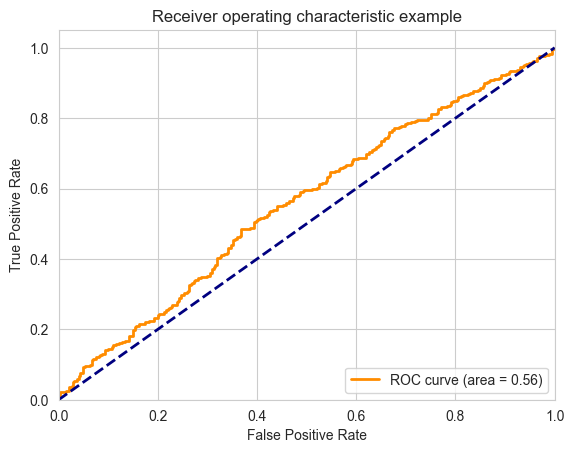

In [50]:
#plot ROC
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(test['profit_binary'], y_pred)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [51]:
#Function to compute confusion matrix and prediction accuracy on test data
def confusion_matrix_test(data,actual_values,model,cutoff=0.5):
#Predict the values using the Logit model
    pred_values = model.predict(data)
# Specify the bins
    bins=np.array([0,cutoff,1])
#Confusion matrix
    cm = np.histogram2d(actual_values, pred_values, bins=bins)[0]
    cm_df = pd.DataFrame(cm)
    cm_df.columns = ['Predicted 0','Predicted 1']
    cm_df = cm_df.rename(index={0: 'Actual 0',1:'Actual 1'})
    accuracy = (cm[0,0]+cm[1,1])/cm.sum()
    sns.heatmap(cm_df, annot=True, cmap='Blues', fmt='g')
    plt.ylabel("Actual Values")
    plt.xlabel("Predicted Values")
    print("Classification accuracy = {:.1%}".format(accuracy))

In [52]:
#Function to compute confusion matrix and prediction accuracy on test/train data
from sklearn.metrics import auc


def confusion_matrix_data(data,actual_values,model,cutoff=0.5):
#Predict the values using the Logit model
    pred_values = model.predict(data)
# Specify the bins
    bins=np.array([0,cutoff,1])
#Confusion matrix
    cm = np.histogram2d(actual_values, pred_values, bins=bins)[0]
    cm_df = pd.DataFrame(cm)
    cm_df.columns = ['Predicted 0','Predicted 1']
    cm_df = cm_df.rename(index={0: 'Actual 0',1:'Actual 1'})
# Calculate the accuracy
    accuracy = (cm[0,0]+cm[1,1])/cm.sum()
    fnr = (cm[1,0])/(cm[1,0]+cm[1,1])
    precision = (cm[1,1])/(cm[0,1]+cm[1,1])
    fpr = (cm[0,1])/(cm[0,0]+cm[0,1])
    tpr = (cm[1,1])/(cm[1,0]+cm[1,1])
    fpr_roc, tpr_roc, auc_thresholds = roc_curve(actual_values, pred_values)
    auc_value = (auc(fpr_roc, tpr_roc))# AUC of ROC
    sns.heatmap(cm_df, annot=True, cmap='Blues', fmt='g')
    plt.ylabel("Actual Values")
    plt.xlabel("Predicted Values")
    print("Classification accuracy = {:.1%}".format(accuracy))
    print("Precision = {:.1%}".format(precision))
    print("TPR or Recall = {:.1%}".format(tpr))
    print("FNR = {:.1%}".format(fnr))
    print("FPR = {:.1%}".format(fpr))
    print("ROC-AUC = {:.1%}".format(auc_value))

Classification accuracy = 55.1%
Precision = 57.2%
TPR or Recall = 67.1%
FNR = 32.9%
FPR = 59.1%
ROC-AUC = 55.8%


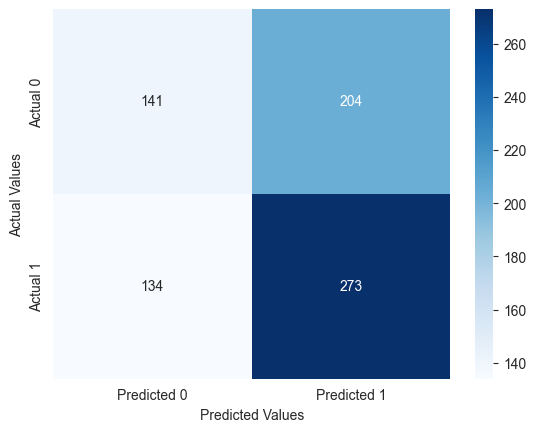

In [53]:
confusion_matrix_data(test,test.profit_binary,logit_model,0.5)

### Code fitting the final model

In [54]:
standard_predictors = ['duration', 'director_facebook_likes', 'actor_3_facebook_likes', 'actor_1_facebook_likes', 'cast_total_facebook_likes', 'facenumber_in_poster', 'actor_2_facebook_likes', 'aspect_ratio']
predictors_actors = ['director_high', 'actor_1_high',  'actor_2_high', 'actor_3_high']
predictors_genre = ['action', 'biography', 'comedy', 'crime', 'documentary', 'drama', 'history', 'horror', 'music', 'musical', 'mystery', 'romance', 'sport', 'thriller', 'war', 'western']
logistic_model = sm.logit(formula='profit_binary ~ ' + ' + '.join(predictors_actors) + ' + ' + ' + '.join(predictors_genre) + ' + ' + ' + '.join(standard_predictors), data=train).fit()


Optimization terminated successfully.
         Current function value: 0.339561
         Iterations 7


In [55]:
#summary
logistic_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:          profit_binary   No. Observations:                 3005
Model:                          Logit   Df Residuals:                     2976
Method:                           MLE   Df Model:                           28
Date:                Wed, 15 Mar 2023   Pseudo R-squ.:                  0.5083
Time:                        14:03:17   Log-Likelihood:                -1020.4
converged:                       True   LL-Null:                       -2075.4
Covariance Type:            nonrobust   LLR p-value:                     0.000
=============================================================================================
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept                    -2.1816      0.560     -3.894      0.000      -3.280      -1.084
director_high                 1.5380      0.120     12.849      0.000       1.303       1.773
actor_1_high                  0.9081      0.123      7.355      0.000       0.666       1.150
actor_2_high                  1.6683      0.119     14.008      0.000       1.435       1.902
actor_3_high                  2.3943      0.118     20.272      0.000       2.163       2.626
action                       -0.0983      0.162     -0.608      0.543      -0.415       0.219
biography                     0.0945      0.255      0.371      0.711      -0.405       0.594
comedy                       -0.1708      0.156     -1.093      0.274      -0.477       0.135
crime                         0.0825      0.158      0.522      0.602      -0.227       0.392
documentary                   2.3691      0.525      4.510      0.000       1.339       3.399
drama                         0.1489      0.142      1.045      0.296      -0.130       0.428
history                       0.1886      0.317      0.595      0.552      -0.433       0.810
horror                        0.5413      0.225      2.401      0.016       0.099       0.983
music                        -0.0037      0.311     -0.012      0.990      -0.613       0.606
musical                       0.2629      0.416      0.632      0.527      -0.552       1.078
mystery                       0.0918      0.200      0.458      0.647      -0.301       0.485
romance                       0.1083      0.144      0.754      0.451      -0.173       0.390
sport                        -0.2821      0.286     -0.986      0.324      -0.842       0.278
thriller                     -0.0823      0.160     -0.514      0.607      -0.396       0.231
war                           0.2786      0.311      0.895      0.371      -0.331       0.888
western                      -0.2646      0.491     -0.539      0.590      -1.226       0.697
duration                     -0.0072      0.003     -2.239      0.025      -0.014      -0.001
director_facebook_likes    1.797e-07   1.88e-05      0.010      0.992   -3.66e-05    3.69e-05
actor_3_facebook_likes     7.688e-06   8.02e-05      0.096      0.924      -0.000       0.000
actor_1_facebook_likes     2.279e-05    4.7e-05      0.485      0.628   -6.93e-05       0.000
cast_total_facebook_likes -2.688e-05   4.68e-05     -0.574      0.566      -0.000    6.49e-05
facenumber_in_poster         -0.0086      0.028     -0.312      0.755      -0.063       0.046
actor_2_facebook_likes     1.888e-05   4.91e-05      0.385      0.701   -7.74e-05       0.000
aspect_ratio                 -0.2209      0.213     -1.036      0.300      -0.639       0.197
=============================================================================================
"""

## Looking at confusion matrix

0.9285809050452238


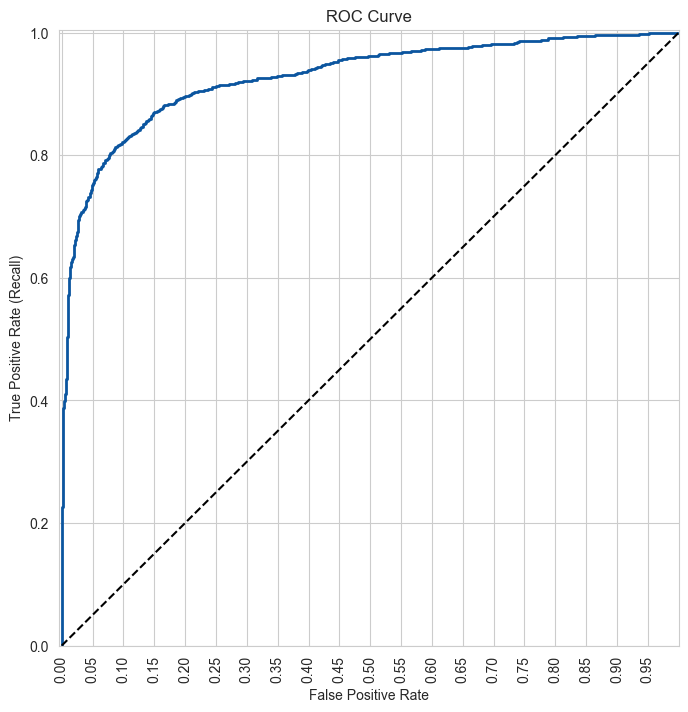

In [56]:
from sklearn.metrics import roc_curve, auc
y=train.profit_binary
ypred = logistic_model.predict(train)
fpr, tpr, auc_thresholds = roc_curve(y, ypred)
print(auc(fpr, tpr))# AUC of ROC
def plot_roc_curve(fpr, tpr, label=None):
    plt.figure(figsize=(8,8))
    plt.title('ROC Curve')
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([-0.005, 1, 0, 1.005])
    plt.xticks(np.arange(0,1, 0.05), rotation=90)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate (Recall)")

fpr, tpr, auc_thresholds = roc_curve(y, ypred)
plot_roc_curve(fpr, tpr)

In [57]:
#Function to compute confusion matrix and prediction accuracy on test/train data
def confusion_matrix_data(data,actual_values,model,cutoff=0.5):
#Predict the values using the Logit model
    pred_values = model.predict(data)
# Specify the bins
    bins=np.array([0,cutoff,1])
#Confusion matrix
    cm = np.histogram2d(actual_values, pred_values, bins=bins)[0]
    cm_df = pd.DataFrame(cm)
    cm_df.columns = ['Predicted 0','Predicted 1']
    cm_df = cm_df.rename(index={0: 'Actual 0',1:'Actual 1'})
# Calculate the accuracy
    accuracy = (cm[0,0]+cm[1,1])/cm.sum()
    fnr = (cm[1,0])/(cm[1,0]+cm[1,1])
    precision = (cm[1,1])/(cm[0,1]+cm[1,1])
    fpr = (cm[0,1])/(cm[0,0]+cm[0,1])
    tpr = (cm[1,1])/(cm[1,0]+cm[1,1])
    fpr_roc, tpr_roc, auc_thresholds = roc_curve(actual_values, pred_values)
    auc_value = (auc(fpr_roc, tpr_roc))# AUC of ROC
    sns.heatmap(cm_df, annot=True, cmap='Blues', fmt='g')
    plt.ylabel("Actual Values")
    plt.xlabel("Predicted Values")
    print("Classification accuracy = {:.1%}".format(accuracy))
    print("Precision = {:.1%}".format(precision))
    print("TPR or Recall = {:.1%}".format(tpr))
    print("FNR = {:.1%}".format(fnr))
    print("FPR = {:.1%}".format(fpr))
    print("ROC-AUC = {:.1%}".format(auc_value))

Classification accuracy = 88.4%
Precision = 88.5%
TPR or Recall = 90.4%
FNR = 9.6%
FPR = 13.9%
ROC-AUC = 93.5%


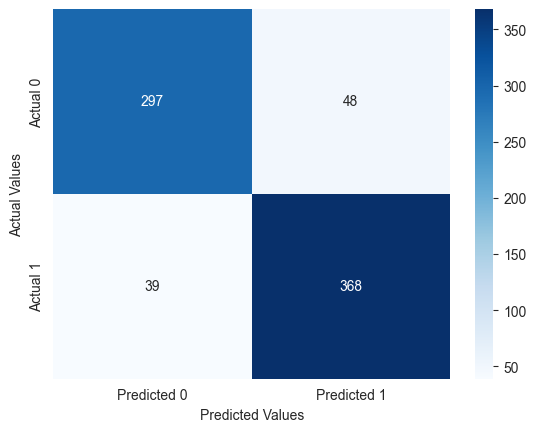

In [58]:
confusion_matrix_data(test,test.profit_binary,logistic_model,0.5)

Precision of 88.5%!

Now, we will investigate which predictors should be removed due to multicollinearity (as demonstrated in the VIF file) by attempting forward, backwards, and best subset selection.

## VIF

In [59]:
standard_predictors = ['duration', 'director_facebook_likes', 'actor_3_facebook_likes', 'actor_1_facebook_likes', 'cast_total_facebook_likes', 'facenumber_in_poster', 'actor_2_facebook_likes', 'aspect_ratio']
predictors_actors = ['director_high', 'actor_1_high',  'actor_2_high', 'actor_3_high']
predictors_genre = ['action', 'biography', 'comedy', 'crime', 'documentary', 'drama', 'history', 'horror', 'music', 'musical', 'mystery', 'romance', 'sport', 'thriller', 'war', 'western']
predictor_subset = predictors_actors + predictors_genre + standard_predictors
#make X from all predictors
X = train[predictor_subset]

In [60]:
#looking at VIF 
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
X = add_constant(X)
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns

for i in range(len(X.columns)):
    vif_data.loc[i,'VIF'] = variance_inflation_factor(X.values, i)

print(vif_data)

                      feature         VIF
0                       const   71.801215
1               director_high    1.327985
2                actor_1_high    1.377578
3                actor_2_high    1.567592
4                actor_3_high    1.639718
5                      action    1.444618
6                   biography    1.248165
7                      comedy    1.741391
8                       crime    1.236430
9                 documentary    1.074414
10                      drama    1.535821
11                    history    1.295977
12                     horror    1.332478
13                      music    1.051483
14                    musical    1.030973
15                    mystery    1.188126
16                    romance    1.179434
17                      sport    1.074692
18                   thriller    1.649509
19                        war    1.185939
20                    western    1.023754
21                   duration    1.376898
22    director_facebook_likes    1

In [61]:
print(vif_data.loc[vif_data.VIF > 10])

                      feature         VIF
0                       const   71.801215
24     actor_1_facebook_likes  228.974152
25  cast_total_facebook_likes  337.717888
27     actor_2_facebook_likes   20.674081


In [62]:
corr = train.corr()[["actor_1_facebook_likes", "cast_total_facebook_likes", "actor_2_facebook_likes"]]
corr > 0.5

,actor_1_facebook_likes,cast_total_facebook_likes,actor_2_facebook_likes
duration,False,False,False
director_facebook_likes,False,False,False
actor_3_facebook_likes,False,False,True
actor_1_facebook_likes,True,True,False
gross,False,False,False
cast_total_facebook_likes,True,True,True
facenumber_in_poster,False,False,False
budget,False,False,False
title_year,False,False,False
actor_2_facebook_likes,False,True,True


As we can see from above, cast_total_facebook_likes, actor_1_facebook_likes, and actor_2_facebook_likes suffer from multicollinearity. They are correlated. I will remove some of these variables to investigate how to reduce the multicollinearity amongst the predictiors.

In [63]:
#removing cast_total_facebook_likes
standard_predictors = ['duration', 'director_facebook_likes', 'actor_3_facebook_likes', 'actor_1_facebook_likes', 'facenumber_in_poster', 'actor_2_facebook_likes', 'aspect_ratio']
predictors_actors = ['director_high', 'actor_1_high',  'actor_2_high', 'actor_3_high']
predictors_genre = ['action', 'biography', 'comedy', 'crime', 'documentary', 'drama', 'history', 'horror', 'music', 'musical', 'mystery', 'romance', 'sport', 'thriller', 'war', 'western']
predictor_subset = predictors_actors + predictors_genre + standard_predictors
#make X from all predictors
X = train[predictor_subset]

In [64]:
#looking at VIF 
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
X = add_constant(X)
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns

for i in range(len(X.columns)):
    vif_data.loc[i,'VIF'] = variance_inflation_factor(X.values, i)

print(vif_data)

                    feature        VIF
0                     const  71.788253
1             director_high   1.327779
2              actor_1_high   1.376170
3              actor_2_high   1.560623
4              actor_3_high   1.639197
5                    action   1.442388
6                 biography   1.248054
7                    comedy   1.737041
8                     crime   1.236296
9               documentary   1.072105
10                    drama   1.532074
11                  history   1.295961
12                   horror   1.332420
13                    music   1.051272
14                  musical   1.030703
15                  mystery   1.188126
16                  romance   1.178943
17                    sport   1.074691
18                 thriller   1.649501
19                      war   1.184504
20                  western   1.023736
21                 duration   1.371566
22  director_facebook_likes   1.063309
23   actor_3_facebook_likes   1.429753
24   actor_1_facebook_lik

In [65]:
print(vif_data.loc[vif_data.VIF > 10])

  feature        VIF
0   const  71.788253


After removing "cast_total_facebook_likes", we observe no more multicollinearity in the data. I will be using this new subset of variables going forward.

## NEW MODEL EXCLUDING MULTICOLLINEARITY

In [66]:
logistic_model = sm.logit(formula='profit_binary ~ ' + ' + '.join(predictor_subset), data=train).fit()


Optimization terminated successfully.
         Current function value: 0.339615
         Iterations 7


In [67]:
logistic_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:          profit_binary   No. Observations:                 3005
Model:                          Logit   Df Residuals:                     2977
Method:                           MLE   Df Model:                           27
Date:                Wed, 15 Mar 2023   Pseudo R-squ.:                  0.5083
Time:                        14:03:21   Log-Likelihood:                -1020.5
converged:                       True   LL-Null:                       -2075.4
Covariance Type:            nonrobust   LLR p-value:                     0.000
===========================================================================================
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                  -2.1754      0.560     -3.883      0.000      -3.273      -1.078
director_high               1.5373      0.120     12.848      0.000       1.303       1.772
actor_1_high                0.9063      0.123      7.343      0.000       0.664       1.148
actor_2_high                1.6634      0.119     14.005      0.000       1.431       1.896
actor_3_high                2.3919      0.118     20.271      0.000       2.161       2.623
action                     -0.1009      0.162     -0.624      0.532      -0.418       0.216
biography                   0.0937      0.255      0.368      0.713      -0.405       0.593
comedy                     -0.1752      0.156     -1.123      0.262      -0.481       0.131
crime                       0.0821      0.158      0.519      0.604      -0.228       0.392
documentary                 2.3774      0.525      4.528      0.000       1.348       3.406
drama                       0.1513      0.142      1.063      0.288      -0.128       0.430
history                     0.1856      0.317      0.586      0.558      -0.435       0.806
horror                      0.5419      0.225      2.404      0.016       0.100       0.984
music                      -0.0065      0.311     -0.021      0.983      -0.616       0.603
musical                     0.2630      0.415      0.633      0.527      -0.551       1.077
mystery                     0.0912      0.200      0.455      0.649      -0.302       0.484
romance                     0.1122      0.143      0.782      0.434      -0.169       0.393
sport                      -0.2811      0.286     -0.983      0.326      -0.841       0.279
thriller                   -0.0819      0.160     -0.511      0.609      -0.396       0.232
war                         0.2858      0.310      0.920      0.357      -0.323       0.894
western                    -0.2638      0.490     -0.539      0.590      -1.223       0.696
duration                   -0.0074      0.003     -2.288      0.022      -0.014      -0.001
director_facebook_likes -2.338e-07   1.87e-05     -0.012      0.990    -3.7e-05    3.65e-05
actor_3_facebook_likes  -3.384e-05   3.31e-05     -1.023      0.306   -9.86e-05     3.1e-05
actor_1_facebook_likes  -4.093e-06   4.21e-06     -0.971      0.331   -1.24e-05    4.17e-06
facenumber_in_poster       -0.0084      0.028     -0.305      0.760      -0.062       0.046
actor_2_facebook_likes  -8.138e-06   1.42e-05     -0.575      0.565   -3.59e-05    1.96e-05
aspect_ratio               -0.2217      0.213     -1.039      0.299      -0.640       0.196
===========================================================================================
"""

In [68]:
np.exp(-0.0074) -1

-0.007372687412573908

0.9286294322231146


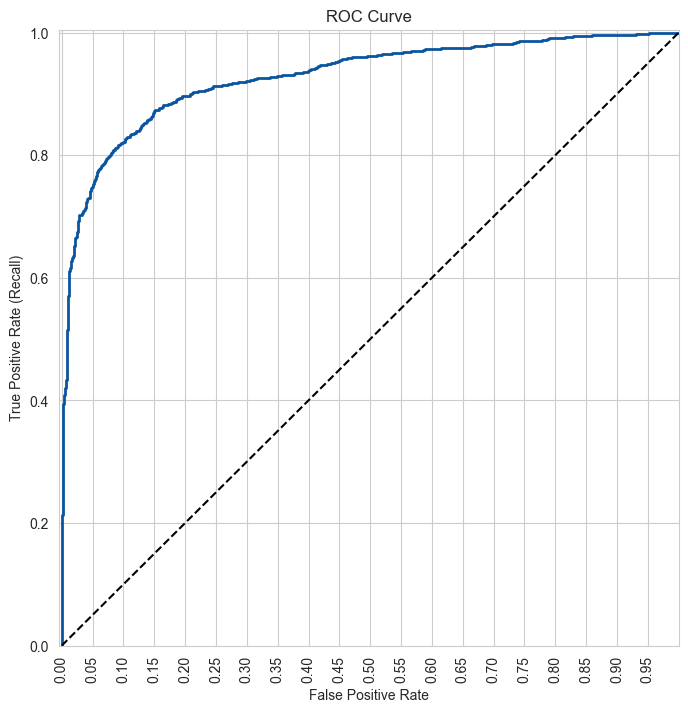

In [69]:
from sklearn.metrics import roc_curve, auc
y=train.profit_binary
ypred = logistic_model.predict(train)
fpr, tpr, auc_thresholds = roc_curve(y, ypred)
print(auc(fpr, tpr))# AUC of ROC
def plot_roc_curve(fpr, tpr, label=None):
    plt.figure(figsize=(8,8))
    plt.title('ROC Curve')
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([-0.005, 1, 0, 1.005])
    plt.xticks(np.arange(0,1, 0.05), rotation=90)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate (Recall)")

fpr, tpr, auc_thresholds = roc_curve(y, ypred)
plot_roc_curve(fpr, tpr)

In [70]:
#Function to compute confusion matrix and prediction accuracy on test/train data
def confusion_matrix_data(data,actual_values,model,cutoff=0.5):
#Predict the values using the Logit model
    pred_values = model.predict(data)
# Specify the bins
    bins=np.array([0,cutoff,1])
#Confusion matrix
    cm = np.histogram2d(actual_values, pred_values, bins=bins)[0]
    cm_df = pd.DataFrame(cm)
    cm_df.columns = ['Predicted 0','Predicted 1']
    cm_df = cm_df.rename(index={0: 'Actual 0',1:'Actual 1'})
# Calculate the accuracy
    accuracy = (cm[0,0]+cm[1,1])/cm.sum()
    fnr = (cm[1,0])/(cm[1,0]+cm[1,1])
    precision = (cm[1,1])/(cm[0,1]+cm[1,1])
    fpr = (cm[0,1])/(cm[0,0]+cm[0,1])
    tpr = (cm[1,1])/(cm[1,0]+cm[1,1])
    fpr_roc, tpr_roc, auc_thresholds = roc_curve(actual_values, pred_values)
    auc_value = (auc(fpr_roc, tpr_roc))# AUC of ROC
    sns.heatmap(cm_df, annot=True, cmap='Blues', fmt='g')
    plt.ylabel("Actual Values")
    plt.xlabel("Predicted Values")
    print("Classification accuracy = {:.1%}".format(accuracy))
    print("Precision = {:.1%}".format(precision))
    print("TPR or Recall = {:.1%}".format(tpr))
    print("FNR = {:.1%}".format(fnr))
    print("FPR = {:.1%}".format(fpr))
    print("ROC-AUC = {:.1%}".format(auc_value))

Classification accuracy = 88.4%
Precision = 88.5%
TPR or Recall = 90.4%
FNR = 9.6%
FPR = 13.9%
ROC-AUC = 93.5%


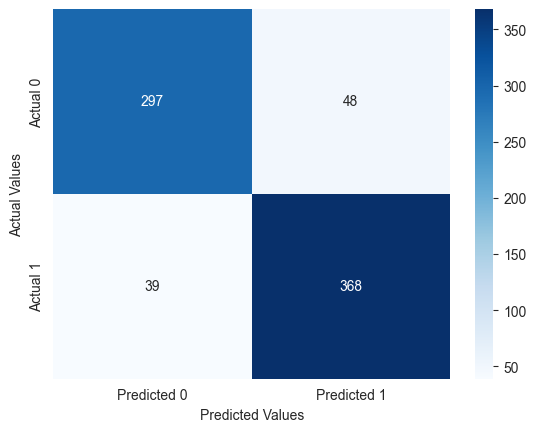

In [71]:
confusion_matrix_data(test,test.profit_binary,logistic_model,0.5)

Precision is still at 88.5% after taking into account multicollinearity.

## Looking at potential interaction terms

It might be that instead of just removing the variable, we could include interactions to remove collinearity. We will investigate whether this model has a higher precision or not.

In [72]:
standard_predictors = ['duration', 'director_facebook_likes', 'actor_3_facebook_likes', 'actor_1_facebook_likes', 'cast_total_facebook_likes', 'facenumber_in_poster', 'actor_2_facebook_likes', 'aspect_ratio']
logistic_model = sm.logit(formula='profit_binary ~ ' + ' + '.join(predictors_actors) + ' + ' + ' + '.join(predictors_genre) + ' + ' + ' + '.join(standard_predictors)  + '+actor_1_facebook_likes*cast_total_facebook_likes+cast_total_facebook_likes*actor_2_facebook_likes', data=train).fit()
logistic_model.summary()

Optimization terminated successfully.
         Current function value: 0.335988
         Iterations 12


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:          profit_binary   No. Observations:                 3005
Model:                          Logit   Df Residuals:                     2974
Method:                           MLE   Df Model:                           30
Date:                Wed, 15 Mar 2023   Pseudo R-squ.:                  0.5135
Time:                        14:03:23   Log-Likelihood:                -1009.6
converged:                       True   LL-Null:                       -2075.4
Covariance Type:            nonrobust   LLR p-value:                     0.000
====================================================================================================================
                                                       coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------------
Intercept                                           -2.3043      0.533     -4.320      0.000      -3.350      -1.259
director_high                                        1.5457      0.121     12.817      0.000       1.309       1.782
actor_1_high                                         1.0422      0.128      8.165      0.000       0.792       1.292
actor_2_high                                         1.6884      0.120     14.036      0.000       1.453       1.924
actor_3_high                                         2.3971      0.119     20.156      0.000       2.164       2.630
action                                              -0.1138      0.163     -0.700      0.484      -0.432       0.205
biography                                            0.1400      0.256      0.548      0.584      -0.361       0.641
comedy                                              -0.2106      0.157     -1.343      0.179      -0.518       0.097
crime                                                0.0818      0.159      0.516      0.606      -0.229       0.393
documentary                                          2.2619      0.526      4.302      0.000       1.231       3.293
drama                                                0.1540      0.143      1.075      0.282      -0.127       0.435
history                                              0.1199      0.318      0.377      0.706      -0.503       0.743
horror                                               0.4877      0.227      2.146      0.032       0.042       0.933
music                                               -0.0461      0.314     -0.147      0.883      -0.662       0.569
musical                                              0.1712      0.420      0.407      0.684      -0.653       0.995
mystery                                              0.1040      0.201      0.517      0.605      -0.290       0.498
romance                                              0.1068      0.144      0.740      0.459      -0.176       0.389
sport                                               -0.2881      0.289     -0.998      0.318      -0.854       0.278
thriller                                            -0.0544      0.161     -0.338      0.735      -0.370       0.261
war                                                  0.2858      0.313      0.913      0.361      -0.328       0.900
western                                             -0.1772      0.500     -0.354      0.723      -1.158       0.804
duration                                            -0.0065      0.003     -1.995      0.046      -0.013      -0.000
director_facebook_likes                            5.79e-06   1.91e-05      0.303      0.762   -3.16e-05    4.32e-05
actor_3_facebook_likes                           -2.108e-05   8.37e-05     -0.252      0.801      -0.000       0.000
actor_1_facebook_likes                           -1.627e-05   5.13e-05     -0.317 

Classification accuracy = 87.1%
Precision = 87.6%
TPR or Recall = 88.7%
FNR = 11.3%
FPR = 14.8%
ROC-AUC = 93.6%


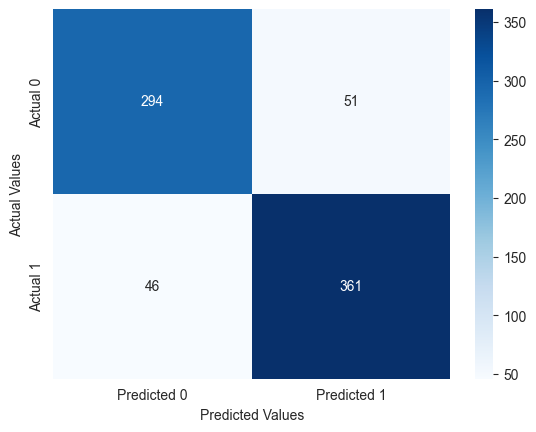

In [73]:
confusion_matrix_data(test,test.profit_binary,logistic_model,0.5)

As we can see, this actually reduces precision (from 88.5 to 87.6), so we did not include these interaction terms. 

## FORWARD SELECTION

In [74]:
#make X from all predictors
X = train[predictor_subset]
X.columns

Index(['director_high', 'actor_1_high', 'actor_2_high', 'actor_3_high',
       'action', 'biography', 'comedy', 'crime', 'documentary', 'drama',
       'history', 'horror', 'music', 'musical', 'mystery', 'romance', 'sport',
       'thriller', 'war', 'western', 'duration', 'director_facebook_likes',
       'actor_3_facebook_likes', 'actor_1_facebook_likes',
       'facenumber_in_poster', 'actor_2_facebook_likes', 'aspect_ratio'],
      dtype='object')

In [75]:
def best_sub_plots():
    plt.figure(figsize=(20,10))
    plt.rcParams.update({'font.size': 18, 'lines.markersize': 10})

    # Set up a 2x2 grid so we can look at 4 plots at once
    plt.subplot(1, 2, 1)

    # We will now plot a red dot to indicate the model with the largest adjusted R^2 statistic.
    # The argmax() function can be used to identify the location of the maximum point of a vector
    plt.plot(models_best["Rsquared"])
    plt.xlabel('# Predictors')
    plt.ylabel('Log likelihood')

    bic = models_best.apply(lambda row: row[1].bic, axis=1)

    plt.subplot(1, 2, 2)
    plt.plot(bic)
    plt.plot(1+bic.argmin(), bic.min(), "or")
    plt.xlabel('# Predictors')
    plt.ylabel('BIC')

In [76]:
#Function to develop a model based on all predictors in predictor_subset
def processSubset(predictor_subset):
    # Fit model on feature_set and calculate R-squared
    model = sm.logit('profit_binary~' + '+'.join(predictor_subset),data = train).fit(disp=0)
    Rsquared = model.llf
    return {"model":model, "Rsquared":Rsquared}

In [77]:
#Function to find the best predictor out of p-k predictors and add it to the model containing the k predictors
def forward(predictors):

    # Pull out predictors we still need to process
    remaining_predictors = [p for p in X.columns if p not in predictors]
    
    tic = time.time()
    
    results = []
    
    for p in remaining_predictors:        
        results.append(processSubset(predictors+[p]))
    
    # Wrap everything up in a nice dataframe
    models = pd.DataFrame(results)
    
    # Choose the model with the highest RSS
    best_model = models.loc[models['Rsquared'].argmax()]
    
    toc = time.time()
    print("Processed ", models.shape[0], "models on", len(predictors)+1, "predictors in", (toc-tic), "seconds.")
    
    # Return the best model, along with some other useful information about the model
    return best_model

In [78]:
def forward_selection():
    models_best = pd.DataFrame(columns=["Rsquared", "model"])

    tic = time.time()
    predictors = []

    for i in range(1,len(X.columns)+1):    
        models_best.loc[i] = forward(predictors)
        predictors = list(models_best.loc[i]["model"].params.index[1:])

    toc = time.time()
    print("Total elapsed time:", (toc-tic), "seconds.")
    return models_best

In [79]:
models_best = forward_selection()

Processed  27 models on 1 predictors in 0.3814811706542969 seconds.
Processed  26 models on 2 predictors in 0.345609188079834 seconds.
Processed  25 models on 3 predictors in 0.44983506202697754 seconds.
Processed  24 models on 4 predictors in 0.6331193447113037 seconds.
Processed  23 models on 5 predictors in 0.607694149017334 seconds.
Processed  22 models on 6 predictors in 0.5730116367340088 seconds.
Processed  21 models on 7 predictors in 0.5445246696472168 seconds.
Processed  20 models on 8 predictors in 0.6181252002716064 seconds.
Processed  19 models on 9 predictors in 0.5758891105651855 seconds.
Processed  18 models on 10 predictors in 0.5937154293060303 seconds.
Processed  17 models on 11 predictors in 0.7829394340515137 seconds.
Processed  16 models on 12 predictors in 0.7644164562225342 seconds.
Processed  15 models on 13 predictors in 0.6872613430023193 seconds.
Processed  14 models on 14 predictors in 0.8076333999633789 seconds.
Processed  13 models on 15 predictors in 0.6

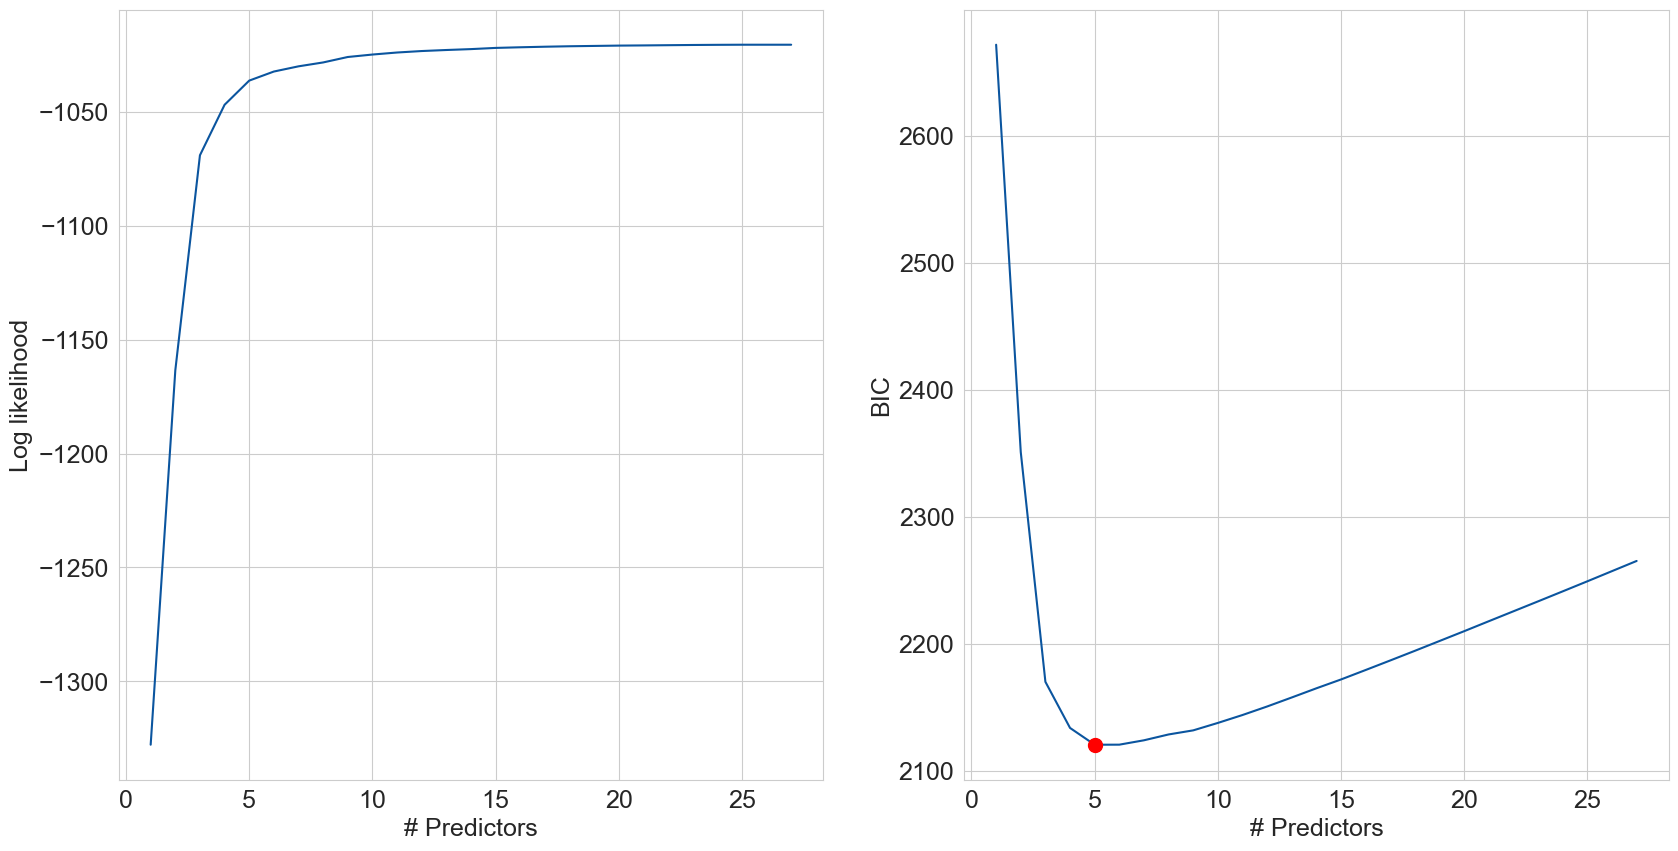

In [80]:
best_sub_plots()

In [81]:
best_fwd_reg_model = models_best['model'][5]
best_fwd_reg_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:          profit_binary   No. Observations:                 3005
Model:                          Logit   Df Residuals:                     2999
Method:                           MLE   Df Model:                            5
Date:                Wed, 15 Mar 2023   Pseudo R-squ.:                  0.5007
Time:                        14:03:39   Log-Likelihood:                -1036.3
converged:                       True   LL-Null:                       -2075.4
Covariance Type:            nonrobust   LLR p-value:                     0.000
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        -3.3618      0.132    -25.408      0.000      -3.621      -3.102
actor_3_high      2.3449      0.114     20.482      0.000       2.120       2.569
actor_2_high      1.6181      0.116     13.927      0.000       1.390       1.846
director_high     1.5056      0.117     12.891      0.000       1.277       1.735
actor_1_high      0.8220      0.119      6.892      0.000       0.588       1.056
documentary       2.4966      0.488      5.116      0.000       1.540       3.453
=================================================================================
"""

Classification accuracy = 88.0%
Precision = 88.2%
TPR or Recall = 89.9%
FNR = 10.1%
FPR = 14.2%
ROC-AUC = 93.2%


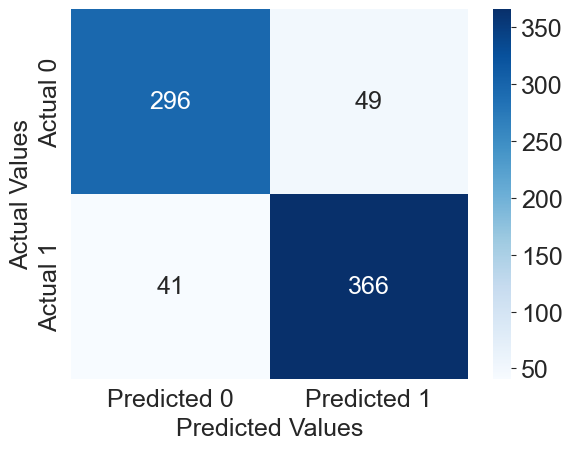

In [82]:
confusion_matrix_data(test,test.profit_binary,best_fwd_reg_model,0.5)

Precision went down from 88.5% to 88.2%, so it might be that forward selection is not the best model to optimize precision. 

## BACKWARDS

In [83]:
def backward(predictors):
    
    tic = time.time()
    
    results = []
    
    for combo in itertools.combinations(predictors, len(predictors)-1):
        results.append(processSubset(combo))
    
    # Wrap everything up in a nice dataframe
    models = pd.DataFrame(results)
    
    # Choose the model with the highest RSS
    best_model = models.loc[models['Rsquared'].argmax()]
    
    toc = time.time()
    print("Processed ", models.shape[0], "models on", len(predictors)-1, "predictors in", (toc-tic), "seconds.")
    
    # Return the best model, along with some other useful information about the model
    return best_model

In [84]:
def backward_selection():
    models_best = pd.DataFrame(columns=["Rsquared", "model"], index = range(1,len(X.columns)))

    tic = time.time()
    predictors = X.columns
    models_best.loc[len(predictors)] = processSubset(predictors)
    
    while(len(predictors) > 1):  
        models_best.loc[len(predictors)-1] = backward(predictors)
        predictors = models_best.loc[len(predictors)-1]["model"].params.index[1:]

    toc = time.time()
    print("Total elapsed time:", (toc-tic), "seconds.")
    return models_best

In [85]:
models_best = backward_selection()


Processed  27 models on 26 predictors in 2.376128911972046 seconds.
Processed  26 models on 25 predictors in 2.248077869415283 seconds.
Processed  25 models on 24 predictors in 1.9729182720184326 seconds.
Processed  24 models on 23 predictors in 2.1251187324523926 seconds.
Processed  23 models on 22 predictors in 1.7882015705108643 seconds.
Processed  22 models on 21 predictors in 1.6433348655700684 seconds.
Processed  21 models on 20 predictors in 1.4337804317474365 seconds.
Processed  20 models on 19 predictors in 1.3710911273956299 seconds.
Processed  19 models on 18 predictors in 1.451486587524414 seconds.
Processed  18 models on 17 predictors in 1.0019896030426025 seconds.
Processed  17 models on 16 predictors in 0.8160386085510254 seconds.
Processed  16 models on 15 predictors in 0.6599318981170654 seconds.
Processed  15 models on 14 predictors in 0.5485153198242188 seconds.
Processed  14 models on 13 predictors in 0.5335509777069092 seconds.
Processed  13 models on 12 predictors

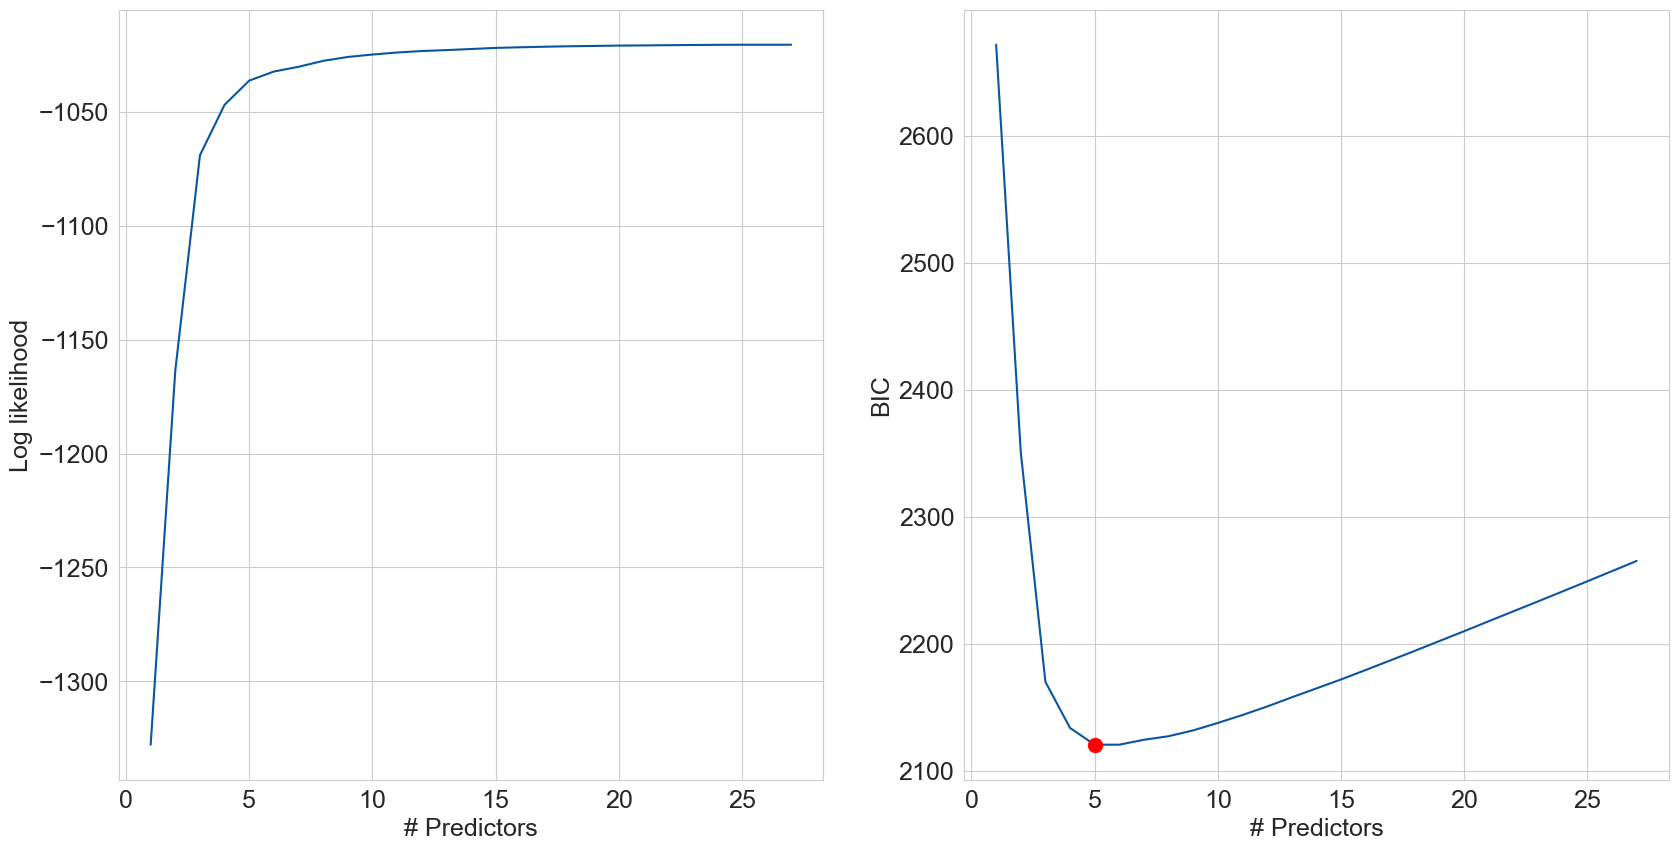

In [86]:
best_sub_plots()

In [87]:
best_bwd_reg_model = models_best['model'][5]
best_bwd_reg_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:          profit_binary   No. Observations:                 3005
Model:                          Logit   Df Residuals:                     2999
Method:                           MLE   Df Model:                            5
Date:                Wed, 15 Mar 2023   Pseudo R-squ.:                  0.5007
Time:                        14:04:05   Log-Likelihood:                -1036.3
converged:                       True   LL-Null:                       -2075.4
Covariance Type:            nonrobust   LLR p-value:                     0.000
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        -3.3618      0.132    -25.408      0.000      -3.621      -3.102
director_high     1.5056      0.117     12.891      0.000       1.277       1.735
actor_1_high      0.8220      0.119      6.892      0.000       0.588       1.056
actor_2_high      1.6181      0.116     13.927      0.000       1.390       1.846
actor_3_high      2.3449      0.114     20.482      0.000       2.120       2.569
documentary       2.4966      0.488      5.116      0.000       1.540       3.453
=================================================================================
"""

Classification accuracy = 88.0%
Precision = 88.2%
TPR or Recall = 89.9%
FNR = 10.1%
FPR = 14.2%
ROC-AUC = 93.2%


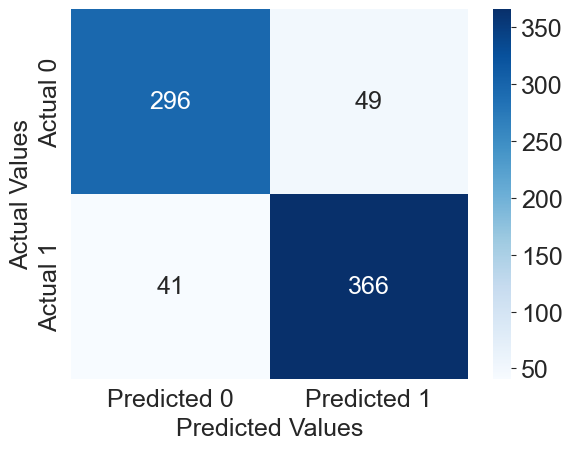

In [88]:
confusion_matrix_data(test,test.profit_binary,best_bwd_reg_model,0.5)

Precision went down from 88.5% to 88.2%, so it might be that backwards selection is not the best model to optimize precision.

## BEST SUBSET SELECTION

In [89]:
#Function to select the best model amongst all models with 'k' predictors
def getBest_model(k):
    tic = time.time()
    results = []
    for combo in itertools.combinations(X.columns, k):
        results.append(processSubset((list(combo))))

    # Wrap everything up in a dataframe
    models = pd.DataFrame(results)

    # Choose the model with the highest RSS
    best_model = models.loc[models['Rsquared'].argmax()]
    
    toc = time.time()
    print("Processed", models.shape[0], "models on", k, "predictors in", (toc-tic), "seconds.")
    return best_model

In [90]:
#Function to select the best model amongst the best models for 'k' predictors, where k = 1,2,3,..
#models_best = pd.DataFrame(columns=["Rsquared", "model"])

#tic = time.time()
#for i in range(1,1+X.shape[1]):
#    models_best.loc[i] = getBest_model(i)

#toc = time.time()
#print("Total elapsed time:", (toc-tic), "seconds.")

The code took way to long to run, so we decided against it.

## PROBLEM: 
The cast profitability variables might pose a problem as creating them was based on average profit of each variable. Due to the fact that only half the actors's names showed up more than once, then the actor names might just be a reflection of profit in different scenarios. This might be a worry since the addition of this variables raised the model from around 50% to 90% precision when predicting whether a movie was profitable or not. In order to investigate this hypothesis, we sought to remake the model without the cast profitability variables.

In [91]:
standard_predictors = ['duration', 'director_facebook_likes', 'actor_3_facebook_likes', 'actor_1_facebook_likes', 'facenumber_in_poster', 'actor_2_facebook_likes', 'aspect_ratio']
logistic_model = sm.logit(formula='profit_binary ~ ' + ' +  '.join(predictors_genre) + ' + ' + ' + '.join(standard_predictors), data=train).fit()

Optimization terminated successfully.
         Current function value: 0.671876
         Iterations 5


In [92]:
logistic_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:          profit_binary   No. Observations:                 3005
Model:                          Logit   Df Residuals:                     2981
Method:                           MLE   Df Model:                           23
Date:                Wed, 15 Mar 2023   Pseudo R-squ.:                 0.02716
Time:                        14:04:06   Log-Likelihood:                -2019.0
converged:                       True   LL-Null:                       -2075.4
Covariance Type:            nonrobust   LLR p-value:                 8.293e-14
===========================================================================================
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                   0.5380      0.366      1.468      0.142      -0.180       1.256
action                     -0.1788      0.104     -1.719      0.086      -0.383       0.025
biography                  -0.0507      0.170     -0.297      0.766      -0.385       0.283
comedy                      0.2189      0.100      2.185      0.029       0.023       0.415
crime                      -0.1074      0.105     -1.019      0.308      -0.314       0.099
documentary                 0.7164      0.363      1.975      0.048       0.005       1.427
drama                      -0.2808      0.092     -3.061      0.002      -0.461      -0.101
history                    -0.3172      0.218     -1.457      0.145      -0.744       0.109
horror                      0.4820      0.143      3.368      0.001       0.201       0.762
music                       0.2448      0.196      1.251      0.211      -0.139       0.628
musical                     0.0321      0.237      0.136      0.892      -0.432       0.496
mystery                     0.0271      0.133      0.204      0.838      -0.233       0.287
romance                     0.0660      0.095      0.691      0.489      -0.121       0.253
sport                       0.0690      0.198      0.348      0.728      -0.319       0.457
thriller                   -0.0261      0.105     -0.249      0.803      -0.231       0.179
war                        -0.4543      0.207     -2.190      0.029      -0.861      -0.048
western                    -0.5532      0.341     -1.622      0.105      -1.222       0.115
duration                    0.0053      0.002      2.702      0.007       0.001       0.009
director_facebook_likes   4.22e-05   1.38e-05      3.066      0.002    1.52e-05    6.92e-05
actor_3_facebook_likes   3.307e-05   2.74e-05      1.207      0.228   -2.06e-05    8.68e-05
actor_1_facebook_likes  -1.933e-07   2.54e-06     -0.076      0.939   -5.18e-06    4.79e-06
facenumber_in_poster       -0.0078      0.018     -0.425      0.671      -0.044       0.028
actor_2_facebook_likes   2.157e-05   1.22e-05      1.764      0.078   -2.39e-06    4.55e-05
aspect_ratio               -0.4676      0.147     -3.184      0.001      -0.755      -0.180
===========================================================================================
"""

In [93]:
np.exp(-0.4676) 

0.6265040751739815

0.6162176938104251


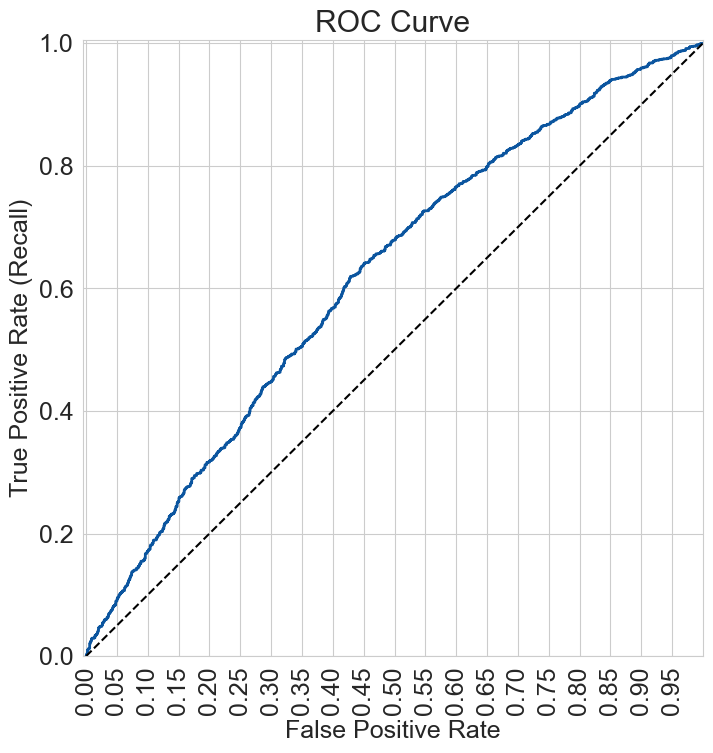

In [94]:
from sklearn.metrics import roc_curve, auc
y=train.profit_binary
ypred = logistic_model.predict(train)
fpr, tpr, auc_thresholds = roc_curve(y, ypred)
print(auc(fpr, tpr))# AUC of ROC
def plot_roc_curve(fpr, tpr, label=None):
    plt.figure(figsize=(8,8))
    plt.title('ROC Curve')
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([-0.005, 1, 0, 1.005])
    plt.xticks(np.arange(0,1, 0.05), rotation=90)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate (Recall)")

fpr, tpr, auc_thresholds = roc_curve(y, ypred)
plot_roc_curve(fpr, tpr)

Classification accuracy = 60.1%
Precision = 61.5%
TPR or Recall = 70.5%
FNR = 29.5%
FPR = 52.2%
ROC-AUC = 62.4%


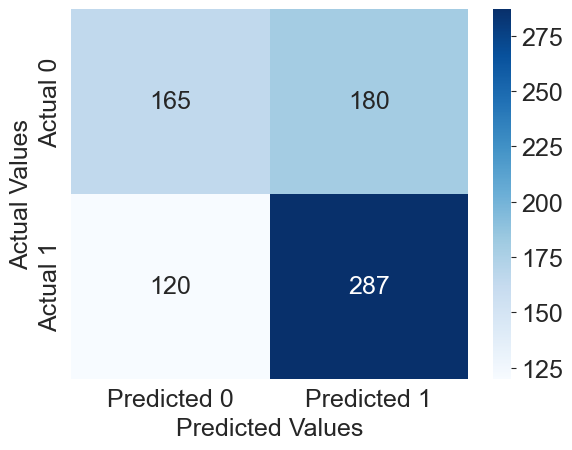

In [95]:
confusion_matrix_data(test,test.profit_binary,logistic_model,0.5)

As we can see, when we remove the variables for the profitability of the cast, the precision of the model only increases slightly. This made us worry about the validity of using the variable.

We further investigated how we could improve the model by aplying all the model transformations we had previously used (fwd, bwd, best, lasso, ridge).


## VIF

In [96]:
X = train[["action", "drama", "aspect_ratio", "director_facebook_likes", "actor_3_facebook_likes", "actor_1_facebook_likes", "actor_2_facebook_likes"]]

In [97]:
#looking at VIF 
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
X = add_constant(X)
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns

for i in range(len(X.columns)):
    vif_data.loc[i,'VIF'] = variance_inflation_factor(X.values, i)

print(vif_data)

                   feature        VIF
0                    const  34.126051
1                   action   1.111994
2                    drama   1.079784
3             aspect_ratio   1.038257
4  director_facebook_likes   1.021092
5   actor_3_facebook_likes   1.396108
6   actor_1_facebook_likes   1.177303
7   actor_2_facebook_likes   1.542478


As we can see, there is no multicollinearity.

We will now investigate if we can improve the model using variable selection.

## FORWARD SELECTION

In [98]:
predictor_subset = predictors_genre + standard_predictors
#make X from all predictors
X = train[predictor_subset]
X.columns

Index(['action', 'biography', 'comedy', 'crime', 'documentary', 'drama',
       'history', 'horror', 'music', 'musical', 'mystery', 'romance', 'sport',
       'thriller', 'war', 'western', 'duration', 'director_facebook_likes',
       'actor_3_facebook_likes', 'actor_1_facebook_likes',
       'facenumber_in_poster', 'actor_2_facebook_likes', 'aspect_ratio'],
      dtype='object')

In [99]:
def best_sub_plots():
    plt.figure(figsize=(20,10))
    plt.rcParams.update({'font.size': 18, 'lines.markersize': 10})

    # Set up a 2x2 grid so we can look at 4 plots at once
    plt.subplot(1, 2, 1)

    # We will now plot a red dot to indicate the model with the largest adjusted R^2 statistic.
    # The argmax() function can be used to identify the location of the maximum point of a vector
    plt.plot(models_best["Rsquared"])
    plt.xlabel('# Predictors')
    plt.ylabel('Log likelihood')

    bic = models_best.apply(lambda row: row[1].bic, axis=1)

    plt.subplot(1, 2, 2)
    plt.plot(bic)
    plt.plot(1+bic.argmin(), bic.min(), "or")
    plt.xlabel('# Predictors')
    plt.ylabel('BIC')

In [100]:
#Function to develop a model based on all predictors in predictor_subset
def processSubset(predictor_subset):
    # Fit model on feature_set and calculate R-squared
    model = sm.logit('profit_binary~' + '+'.join(predictor_subset),data = train).fit(disp=0)
    Rsquared = model.llf
    return {"model":model, "Rsquared":Rsquared}

In [101]:
#Function to find the best predictor out of p-k predictors and add it to the model containing the k predictors
def forward(predictors):

    # Pull out predictors we still need to process
    remaining_predictors = [p for p in X.columns if p not in predictors]
    
    tic = time.time()
    
    results = []
    
    for p in remaining_predictors:        
        results.append(processSubset(predictors+[p]))
    
    # Wrap everything up in a nice dataframe
    models = pd.DataFrame(results)
    
    # Choose the model with the highest RSS
    best_model = models.loc[models['Rsquared'].argmax()]
    
    toc = time.time()
    print("Processed ", models.shape[0], "models on", len(predictors)+1, "predictors in", (toc-tic), "seconds.")
    
    # Return the best model, along with some other useful information about the model
    return best_model

In [102]:
def forward_selection():
    models_best = pd.DataFrame(columns=["Rsquared", "model"])

    tic = time.time()
    predictors = []

    for i in range(1,len(X.columns)+1):    
        models_best.loc[i] = forward(predictors)
        predictors = list(models_best.loc[i]["model"].params.index[1:])

    toc = time.time()
    print("Total elapsed time:", (toc-tic), "seconds.")
    return models_best

In [103]:
models_best = forward_selection()

Processed  23 models on 1 predictors in 0.23607230186462402 seconds.
Processed  22 models on 2 predictors in 0.344191312789917 seconds.
Processed  21 models on 3 predictors in 0.44722700119018555 seconds.
Processed  20 models on 4 predictors in 0.5026040077209473 seconds.
Processed  19 models on 5 predictors in 0.4582393169403076 seconds.
Processed  18 models on 6 predictors in 0.5101311206817627 seconds.
Processed  17 models on 7 predictors in 0.6211767196655273 seconds.
Processed  16 models on 8 predictors in 0.4865999221801758 seconds.
Processed  15 models on 9 predictors in 0.5945508480072021 seconds.
Processed  14 models on 10 predictors in 0.5721721649169922 seconds.
Processed  13 models on 11 predictors in 0.4448094367980957 seconds.
Processed  12 models on 12 predictors in 0.45980048179626465 seconds.
Processed  11 models on 13 predictors in 0.5078003406524658 seconds.
Processed  10 models on 14 predictors in 0.4168131351470947 seconds.
Processed  9 models on 15 predictors in 0

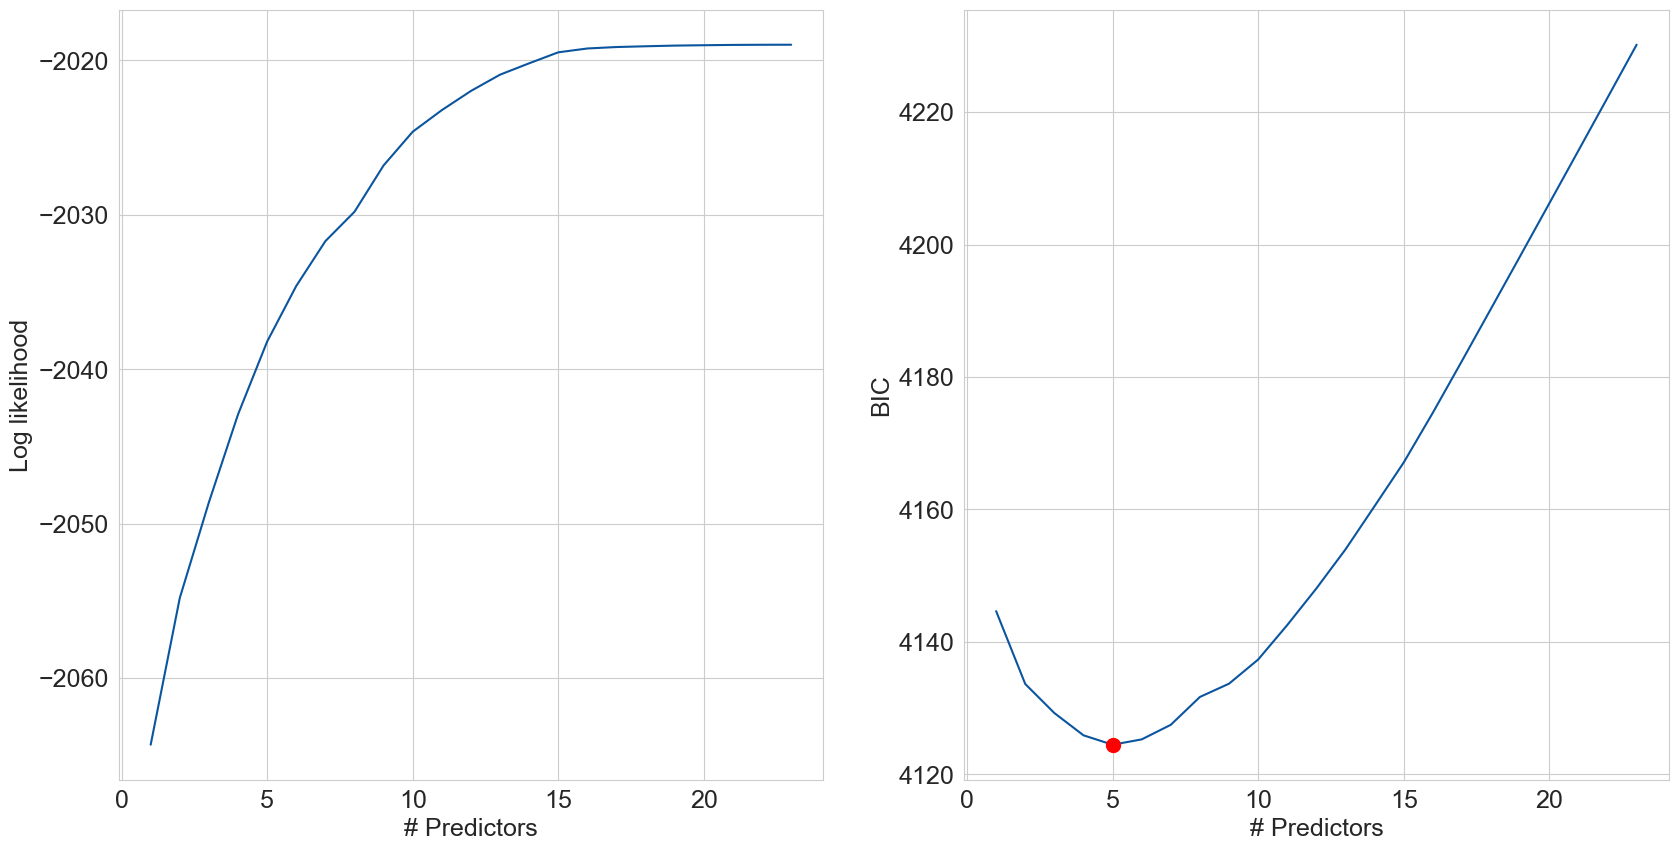

In [104]:
best_sub_plots()

In [105]:
best_fwd_reg_model = models_best['model'][5]
best_fwd_reg_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:          profit_binary   No. Observations:                 3005
Model:                          Logit   Df Residuals:                     2999
Method:                           MLE   Df Model:                            5
Date:                Wed, 15 Mar 2023   Pseudo R-squ.:                 0.01790
Time:                        14:04:18   Log-Likelihood:                -2038.2
converged:                       True   LL-Null:                       -2075.4
Covariance Type:            nonrobust   LLR p-value:                 1.313e-14
===========================================================================================
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                   1.4081      0.294      4.784      0.000       0.831       1.985
drama                      -0.4305      0.077     -5.556      0.000      -0.582      -0.279
aspect_ratio               -0.4990      0.141     -3.530      0.000      -0.776      -0.222
director_facebook_likes   4.12e-05   1.34e-05      3.077      0.002     1.5e-05    6.74e-05
action                     -0.3253      0.092     -3.536      0.000      -0.506      -0.145
actor_2_facebook_likes    2.81e-05   9.63e-06      2.919      0.004    9.23e-06     4.7e-05
===========================================================================================
"""

As we can see, different variables were selected in this case compared to the initial model. 

Classification accuracy = 57.2%
Precision = 58.8%
TPR or Recall = 69.5%
FNR = 30.5%
FPR = 57.4%
ROC-AUC = 58.9%


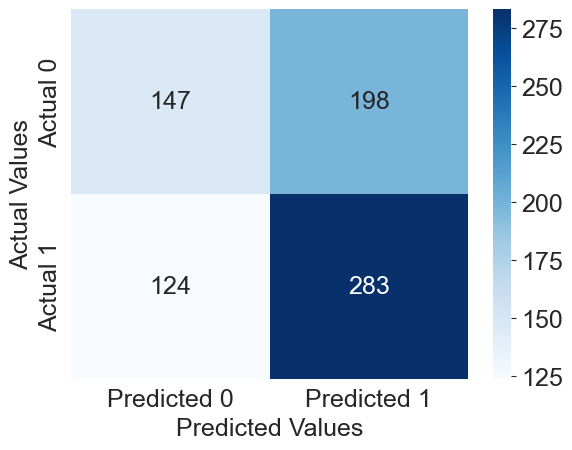

In [106]:
confusion_matrix_data(test,test.profit_binary,best_fwd_reg_model,0.5)

Again, precision does not increase when using forward selection.

## BACKWARDS

In [107]:
def backward(predictors):
    
    tic = time.time()
    
    results = []
    
    for combo in itertools.combinations(predictors, len(predictors)-1):
        results.append(processSubset(combo))
    
    # Wrap everything up in a nice dataframe
    models = pd.DataFrame(results)
    
    # Choose the model with the highest RSS
    best_model = models.loc[models['Rsquared'].argmax()]
    
    toc = time.time()
    print("Processed ", models.shape[0], "models on", len(predictors)-1, "predictors in", (toc-tic), "seconds.")
    
    # Return the best model, along with some other useful information about the model
    return best_model

In [108]:
def backward_selection():
    models_best = pd.DataFrame(columns=["Rsquared", "model"], index = range(1,len(X.columns)))

    tic = time.time()
    predictors = X.columns
    models_best.loc[len(predictors)] = processSubset(predictors)
    
    while(len(predictors) > 1):  
        models_best.loc[len(predictors)-1] = backward(predictors)
        predictors = models_best.loc[len(predictors)-1]["model"].params.index[1:]

    toc = time.time()
    print("Total elapsed time:", (toc-tic), "seconds.")
    return models_best

In [109]:
models_best = backward_selection()


Processed  23 models on 22 predictors in 1.471256971359253 seconds.
Processed  22 models on 21 predictors in 1.2282772064208984 seconds.
Processed  21 models on 20 predictors in 1.2650527954101562 seconds.
Processed  20 models on 19 predictors in 1.0144801139831543 seconds.
Processed  19 models on 18 predictors in 0.9057612419128418 seconds.
Processed  18 models on 17 predictors in 0.6523287296295166 seconds.
Processed  17 models on 16 predictors in 0.6692461967468262 seconds.
Processed  16 models on 15 predictors in 0.5525801181793213 seconds.
Processed  15 models on 14 predictors in 0.46468257904052734 seconds.
Processed  14 models on 13 predictors in 0.41112852096557617 seconds.
Processed  13 models on 12 predictors in 0.46764087677001953 seconds.
Processed  12 models on 11 predictors in 0.3116171360015869 seconds.
Processed  11 models on 10 predictors in 0.3335576057434082 seconds.
Processed  10 models on 9 predictors in 0.2516615390777588 seconds.
Processed  9 models on 8 predicto

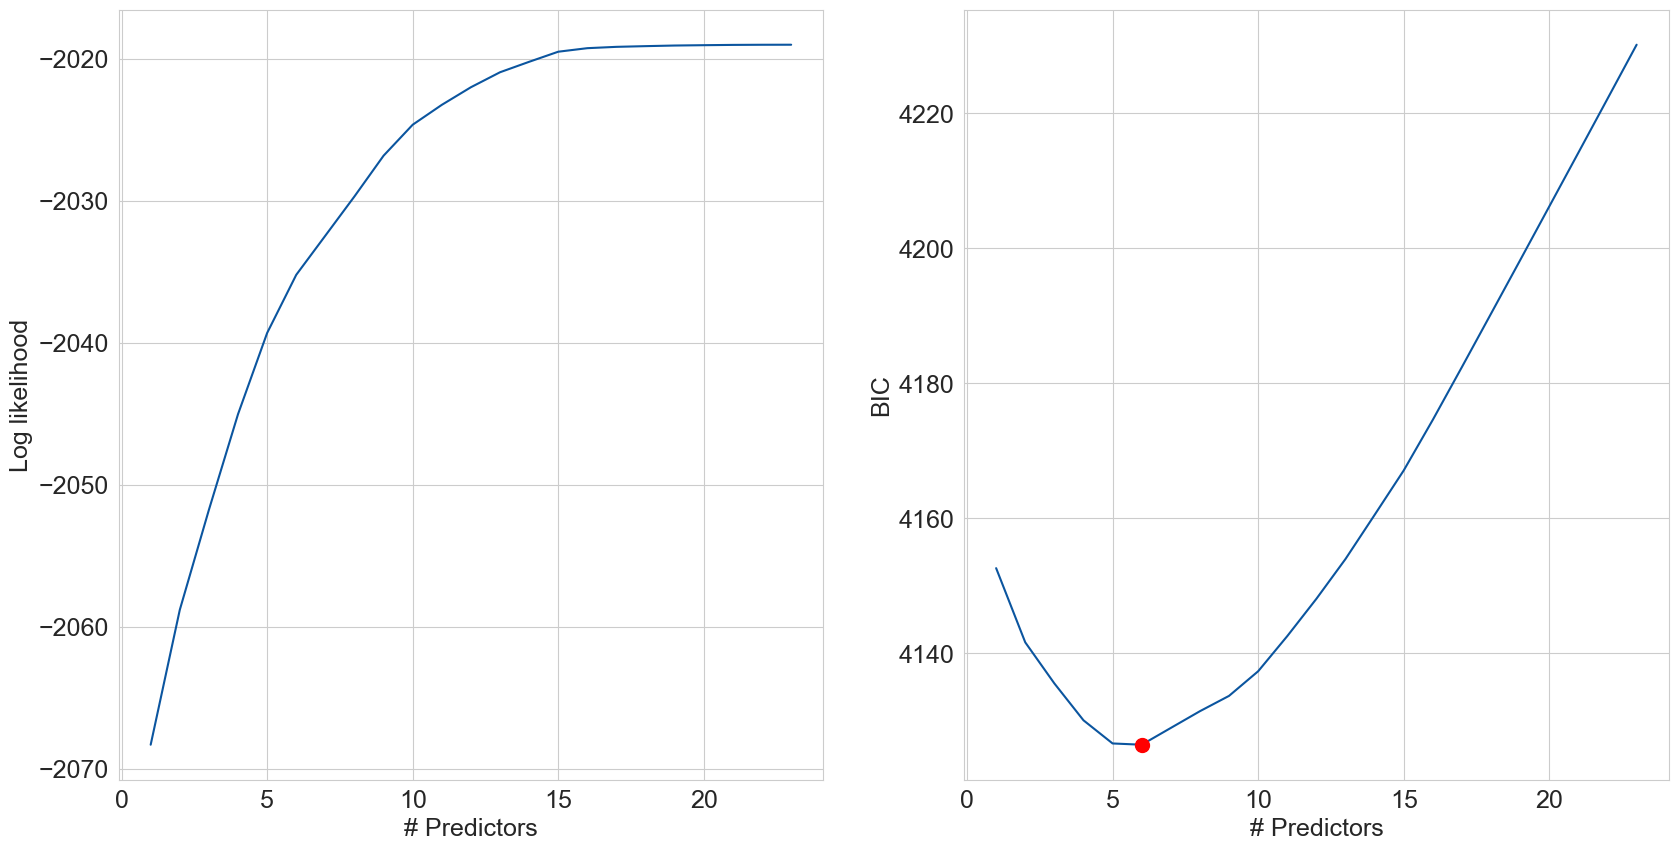

In [110]:
best_sub_plots()

In [111]:
best_bwd_reg_model = models_best['model'][8]
best_bwd_reg_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:          profit_binary   No. Observations:                 3005
Model:                          Logit   Df Residuals:                     2996
Method:                           MLE   Df Model:                            8
Date:                Wed, 15 Mar 2023   Pseudo R-squ.:                 0.02201
Time:                        14:04:31   Log-Likelihood:                -2029.7
converged:                       True   LL-Null:                       -2075.4
Covariance Type:            nonrobust   LLR p-value:                 2.461e-16
===========================================================================================
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                   0.7733      0.357      2.163      0.031       0.073       1.474
comedy                      0.2797      0.087      3.212      0.001       0.109       0.450
drama                      -0.2336      0.081     -2.872      0.004      -0.393      -0.074
horror                      0.5288      0.134      3.936      0.000       0.266       0.792
war                        -0.5264      0.197     -2.667      0.008      -0.913      -0.140
duration                    0.0045      0.002      2.337      0.019       0.001       0.008
director_facebook_likes  4.229e-05   1.36e-05      3.107      0.002    1.56e-05     6.9e-05
actor_2_facebook_likes   2.826e-05   9.73e-06      2.903      0.004    9.18e-06    4.73e-05
aspect_ratio               -0.5852      0.143     -4.091      0.000      -0.866      -0.305
===========================================================================================
"""

Classification accuracy = 59.6%
Precision = 61.0%
TPR or Recall = 70.3%
FNR = 29.7%
FPR = 53.0%
ROC-AUC = 60.3%


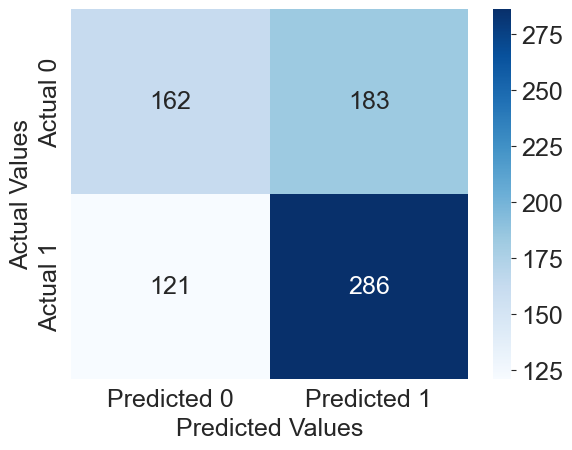

In [112]:
confusion_matrix_data(test,test.profit_binary,best_bwd_reg_model,0.5)

In this case, backwards selection did lead to a better precision from 57.2% to 60.1%. The variables selected are action, drama, the facebook likes variables, and aspect_ratio. On another hand, one might expect multicollinearity amonst the facebook like variables. We investigated VIF for this model to further investigate this:

In [113]:
X = train[["action", "drama", "aspect_ratio", "cast_total_facebook_likes", "director_facebook_likes", "actor_3_facebook_likes", "actor_2_facebook_likes"]]

In [114]:
#looking at VIF 
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
X = add_constant(X)
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns

for i in range(len(X.columns)):
    vif_data.loc[i,'VIF'] = variance_inflation_factor(X.values, i)

print(vif_data)

                     feature        VIF
0                      const  34.137421
1                     action   1.112161
2                      drama   1.079577
3               aspect_ratio   1.038270
4  cast_total_facebook_likes   1.733860
5    director_facebook_likes   1.021301
6     actor_3_facebook_likes   1.451828
7     actor_2_facebook_likes   1.878275


**FINAL MODEL WITHOUT PROFITABLE CAST VARIBLES**

In [117]:
logistic_model = sm.logit(formula='profit_binary~action+biography+comedy+crime+documentary+drama+history+horror+music+musical+mystery+romance+sport+thriller+war+western+duration+director_facebook_likes+actor_3_facebook_likes+actor_1_facebook_likes+facenumber_in_poster+actor_2_facebook_likes+aspect_ratio', data=train).fit()

Optimization terminated successfully.
         Current function value: 0.671876
         Iterations 5


**FINAL MODEL WITH PROFITABLE CAST VARIBLES**

In [115]:

logistic_model = sm.logit(formula='profit_binary~director_high+actor_1_high+actor_2_high+actor_3_high+action+biography+comedy+crime+documentary+drama+history+horror+music+musical+mystery+romance+sport+thriller+war+western+duration+director_facebook_likes+actor_3_facebook_likes+actor_1_facebook_likes+facenumber_in_poster+actor_2_facebook_likes+aspect_ratio', data=train).fit()


Optimization terminated successfully.
         Current function value: 0.339615
         Iterations 7
